# Проект: Маркетинг

## Цель исследования

Построить ML-модель, которая: 
- прогнозирует вероятность покупки покупателем в течение ближайших 90 дней

Метрика качества модели:
- ROC-AUC 

## Исходные данные

1) датасет №1 - apparel-purchases (содержит историю покупок клиентов)
- client_id - идентификатор пользователя
- quantity - количество товаров в заказе
- price - цена товара
- category_ids - вложенные категории, к которым отнсится товар
- date - дата покупки
- message_id - идентификатор сообщения из рассылки

2) датасет №2 - apparel-messages (рассылки, которые были отправлены клиентам):
- bulk_campaign_id - идентификатор рассылки
- client_id - идентификатор клиента
- message_id - идентификатор сообщения
- event - действие клиента с сообщением из рассылки (отправлено, открыл, перешел по ссылке и т. п.)
- channel - канал рассылки
- date - дата действия клиента
- created_at - дата рассылки (время полностью)

3) датасет №3 - target (вероятность покупки)
- client_id - идентификатор клиента
- target - клиент совершил покупку в целевом периоде (1 или 0)

4) датасет №4 - full_campaign_daily_event (агрегация общей базы рассылок по дням и типам событий)
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event - общее количество каждого события event (сколько было кликов, переходов по кампании в разрезе дней)
- nunique_event - количество уникальных client_id в каждом событии

5) датасет №5 - full_campaign_daily_event_channel (агрегация по дням с учетом событий и каналов рассылки)
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event_channel - общее количество каждого события по каналам (сколько было кликов, переходов по кампании в разрезе каналов - почта или пуш на мобильный)
- nunique_event_channel - количество уникальных client_id по событиям и каналам

## План работы

1. Загрузка данных
2. Предобработка исходных данных
3. Исследовательский анализ данных, поиск аномалий 
4. Разработка и тестирование моделей прогнозирования
5. Выводы

# Исследование

## Загрузка библиотек и функций

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import phik
import sklearn
import ast
import shap

from scipy.stats import anderson
from scipy.stats import mannwhitneyu

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, auc

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from  sklearn.linear_model import  LogisticRegression

from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix

RANDOM_STATE = 25
TEST_SIZE = 0.25

In [3]:
print(sklearn.__version__)

1.5.0


In [4]:
# пользовательская функция для анализа данных числового типа 
# вычисляет для заданного датасета и его поля:
# (1) статистические характеристики - среднее, медиану, стандартное отклонение;
# (2) создает гистограмму 
# (3) и боксплот на общей оси x; 
# (4) выполняет тест Андерсона на нормальность распределения значений 

def num_stat_description (dataset, col, bins, title):

    # задаем на полотне два графика, один под другим, с общей осью х
    fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(15, 7), sharex=True) 

    # (1) вычисляем статистические характеристики
    mean = dataset[col].mean()
    median = dataset[col].median()
    std = dataset[col].std()

    # (2) создаем гистограмму
    dataset[col].hist(bins=bins, label=col, ax=ax_hist)
        
    # наносим на гистограмму среднее и медиану 
    ax_hist.axvline(x=mean, color='red', linestyle='solid', linewidth=2, label=f'Mean: {mean:.2f}')
    ax_hist.axvline(x=median, color='orange', linestyle='solid', linewidth=2, label=f'Median: {median:.2f}')

    # наносим на гистограмму также и ско
    ax_hist.axvline(x=mean + std, color='green', linestyle='dashed', linewidth=2, label=f'+1Std: {std:.2f}')
    ax_hist.axvline(x=mean - std, color='green', linestyle='dashed', linewidth=2, label=f'-1Std: {-std:.2f}')
    
    ax_hist.axvline(x=mean + 2 * std, color='orange', linestyle='dashed', linewidth=2, label=f'+2Std: {2*std:.2f}')
    ax_hist.axvline(x=mean - 2 * std, color='orange', linestyle='dashed', linewidth=2, label=f'-2Std: {-2*std:.2f}')
    
    ax_hist.axvline(x=mean + 3 * std, color='red', linestyle='dashed', linewidth=2, label=f'+3Std: {3*std:.2f}')
    ax_hist.axvline(x=mean - 3 * std, color='red', linestyle='dashed', linewidth=2, label=f'-3Std: {-3*std:.2f}')


    # (3) боксплот (развернут горизонтально)
    boxplot = dataset.boxplot(column=col, vert=False, ax=ax_box)

    ax_hist.set_ylabel('Частота значений')
    ax_hist.legend(bbox_to_anchor=(1, 1))
    plt.suptitle(title)
    plt.show()
    
    # Тест Андерсона-Дарлинга на нормальное распределение 
    result = anderson(dataset[col])
    significance_level = 1  # 1% уровень значимости
    critical_value = result.critical_values[result.significance_level == significance_level][0]

    if result.statistic < critical_value:
        print(f'Данные распределены нормально для {significance_level}% уровня значимости теста Андерсона')
    else:
        print(f'Данные не распределены нормально для {significance_level}% уровня значимости теста Андерсона')

In [5]:
# пользовательская функция для анализа данных категориального типа с небольшим количеством категорий
# или для данных дискретного числового типа  
# выводит круговую диаграмму

def discrete_data_distribution(dataset, feature):


    # создаем таблицу с распределением значений признака
    distribution = pd.DataFrame(dataset[feature].value_counts())
    distribution.columns = [f"Распределение по {feature}"]

    # настраиваем размеры фигуры
    plt.figure(figsize=(5, 5))

    # Создаем круговую диаграмму
    wedges, texts, autotexts = plt.pie(distribution[f"Распределение по {feature}"], 
                                       colors=['orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue'], 
                                       startangle=90, 
                                       autopct='%1.1f%%', 
                                       pctdistance=0.85)

    # Настройки легенды
    plt.legend(wedges, distribution.index, title=f"Категории {feature}", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Устанавливаем заголовок диаграммы
    plt.title(f"Распределение по {feature}")
    
    # Отображаем диаграмму
    plt.show()

## Загрузка данных

In [6]:
purchases = pd.read_csv('data/apparel-purchases.csv')

display(purchases.head(5))
purchases.info()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


**Выводы по набору данных (purchases):**

- всего 202 208 записей в датасете, 6 полей;
- предварительно данные соответствуют описанию;
- пропусков нет;
- названия полей соответствуют змеиному стилю (но это некритично);
- неявных дублей пока не обнаружено;


- есть несоответствие типа данных: 
- (1) поле с датой имеет тип object (date);
- (2) поле с категориями покупок записаны как список, элементами которого являются строки - если нам понадобится подавать их как входящие признаки, список нужно будет разделить на отдельные элементы каждый в своем отдельном столбце, элементы следует преобразовать к числовому типу, на случай если нужно будет, например найти насколько определенные покупки/категории близки к друг другу - следовательно потребуется вычислить расстояние в многомерном пространстве. 

In [7]:
messages = pd.read_csv('data/apparel-messages.csv')

display(messages.head(5))
messages.info()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


**Выводы по набору данных (messages):**

- всего 1 миллион 273 тысячи 798 записей в датасете, 7 полей;
- предварительно данные соответствуют описанию;
- названия полей соответствуют змеиному стилю;
- неявных дублей пока не обнаружено;
- наличие пропусков пока не можем подвердить;
- есть несоответствие типа данных: 
- поля с датами имеют тип object (date, created_at).

In [8]:
target = pd.read_csv('data/apparel-target_binary.csv')

display(target.head(5))
target.info()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


**Выводы по набору данных (target):**

- всего 49 849 записей в датасете и 2 поля;
- предварительно данные соответствуют описанию;
- названия полей соответствуют змеиному стилю;
- неявных дублей пока не обнаружено;
- несоответствие типа данных не обнаружено.

In [9]:
full_campaign_daily_event = pd.read_csv('data/full_campaign_daily_event.csv')

display(full_campaign_daily_event.head(5))
full_campaign_daily_event.info()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

**Выводы по набору данных (full_campaign_daily_event):**

- всего 131 тысяча 072 записей в датасете, 24 поля;
- предварительно данные соответствуют описанию;
- названия полей соответствуют змеиному стилю;
- пропусков нет;
- неявных дублей пока не обнаружено;
- поле с датами имеет тип object (date).

In [10]:
full_campaign_daily_event_channel = pd.read_csv('data/full_campaign_daily_event_channel.csv')

display(full_campaign_daily_event_channel.head(5))
full_campaign_daily_event_channel.info()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

**Выводы по набору данных (full_campaign_daily_event_channel):**

- всего 131 тысяча 072 записей в датасете, 35 полей;
- предварительно данные соответствуют описанию;
- названия полей соответствуют змеиному стилю;
- пропусков нет;
- неявных дублей пока не обнаружено;
- поле с датами имеет тип object (date).

**Общие выводы по этапу:**
Данные, которые могут быть использованы как входящие признаки даны в более развернутом виде, чем требуется для будущей модели, где данные нужны строго в разрезе клиентов (как в датасете с таргетом).

Это означает, что непосредственно для модели нужно будет использовать сгруппированные данные из имеющихся датасетов, например средние значения количества покупок, среденего чека или других показателей.

## Предобработка данных

Задачи этапа предобработки:
- наличие полных дубликатов записей;
- проверка и устранение некорректных типов данных (в нашем случае это поля с данными типа object, которые по факту содержат даты);
- проверка и устранение пропусков данных;
- наличие неявных дубликатов значений (в текстовых полях).

In [11]:
# поиск дубликатов в датасете с покупками
purchases.duplicated().sum()

73020

In [12]:
# визуальный анализ дубликатов в покупках
purchases[purchases.duplicated(keep=False)].head(10)

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
58,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
61,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078


В покупках у нас сходу очень много дубликатов - порядка 30%. 

Как показывает таблица выше, однозначно определить что это дубликаты нам не позволяет отсутствие ВРЕМЕНИ совершения покупок -  есть только дата. 

В теории клиенты могут пройти по одной и той же ссылке промо-сообщения и купить несолько раз в один день, почему бы и нет (если там ценовая акция к примеру и механика акции позволяет так делать). 
Поэтому, в этом датасете оставим все записи как есть.

PS
Хотя сомнения есть, слишком уж их много. В реальной задаче на практике это можно и нужно проверить по общей сумме выручки предприятия в финансовой отчетности за определенный период - но здесь у нас такой возможности нет.

In [13]:
# поиск дубликатов в датасете с рассылками
messages.duplicated().sum()

48610

In [14]:
messages[messages.duplicated(keep=False)].head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966465,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967281,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967566,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967567,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967903,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02
967904,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02


В датасете с рассылками у нас также имеются дубли - порядка 3%. Если проанализировать записи на выгрузке выше - то тут действительно имеют место дубли безо всяких сомнений - время совпадает до секунды - поэтому удалим без вопросов.

In [15]:
# удаление дубликатов в рассылках
messages = messages.drop_duplicates()

In [16]:
# дубликаты в датасете в отчете по рассылкам в разрезе дней
full_campaign_daily_event.duplicated().sum()

0

In [17]:
# дубликаты в датасете в отчете по рассылкам в разрезе каналов
full_campaign_daily_event_channel.duplicated().sum()

0

Вывод: в последних двух наборах данных дубликатов нет

In [18]:
# приведение типа данных - к типу дата 

purchases['date'] = pd.to_datetime(purchases['date'], errors='coerce')
messages['date'] = pd.to_datetime(messages['date'], errors='coerce')
messages['created_at'] = pd.to_datetime(messages['created_at'], errors='coerce')

full_campaign_daily_event['date'] = pd.to_datetime(full_campaign_daily_event['date'], errors='coerce')
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'], errors='coerce')

In [19]:
# количество пропусков в датасете рассылок
missing_data = pd.DataFrame(
    messages.isna().mean()*100, columns=['Процент отсутствующих значений']
)

missing_data.sort_values('Процент отсутствующих значений', ascending=False).style.format('{:.1f}%') 

,Процент отсутствующих значений
bulk_campaign_id,0.0%
client_id,0.0%
message_id,0.0%
event,0.0%
channel,0.0%
date,0.0%
created_at,0.0%


Пропусков в датасете рассылок нет, в остальных датасетах - как мы уже видели на этапе загрузки - также нет.

Проверим теперь наличие неявных дубликатов в текстовых полях:

In [20]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [21]:
messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Неявных дубликатов нет.

Выводы по этапу предобработки:

- [x] обработаны полные дубликаты записей в purchases и messages;
- [x] неявные дубликаты значений в текстовых полях не обнаружены;
- [x] преобразованы типы данных (даты и поле с категориями в purchases).

## Исследовательский анализ

### Датасет purchases

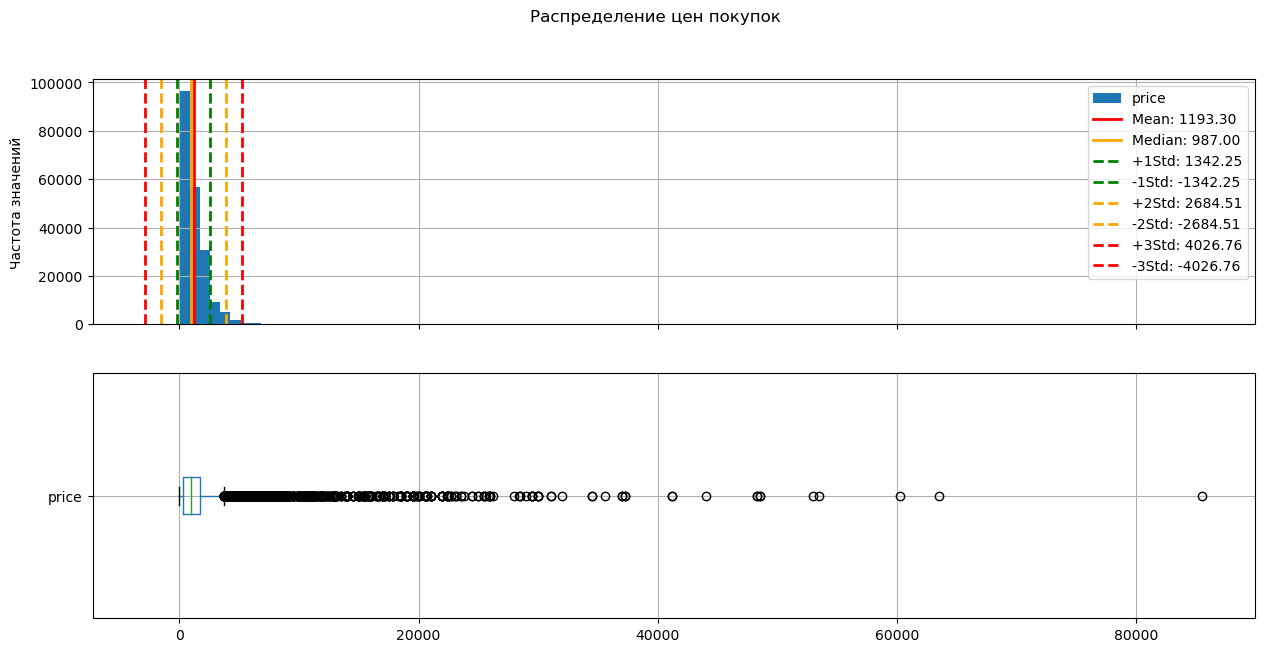

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [22]:
num_stat_description(purchases, 'price', 100, 'Распределение цен покупок')

Здесь можем видеть, что:
- значения цен покупок распределены несимметрично: вытянутый хвост справа - из-за того что цены не могут быть отрицательными, а среднее расположено достаточно близко к нулю - и соответственно, как это характерно, для несимметричных распределений медиана (оранжевая линия) отличается от среднего (красная линия) - 987 против 1193;
- есть выбросы справа: это значения более 5000;
- стандартное отклонение составляет 1342;
- данные не распределены нормально согласно теста Андерсона (при 1% уровне значимости);
- нулевых и отрицательных значений нет (на диаграмме выше это визуально не видно).

Проверим наличие нулевых значений:

In [23]:
purchases.query('price <= 0')['price'].count()

0

Выбросы оставим здесь как есть - покупки по цене от 5 тыс до 80 тыс и выше - они вполне реалистичны (если речь идет о российском интернет магазине, например электронной техники).

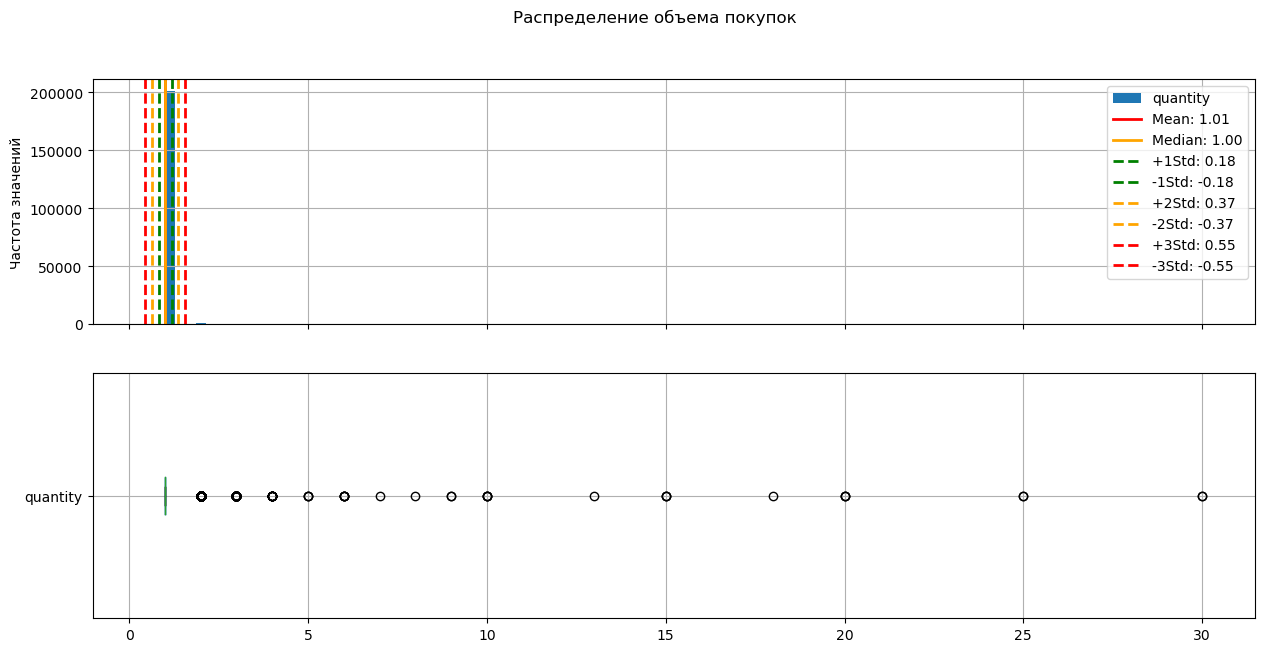

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [24]:
num_stat_description(purchases, 'quantity', 100, 'Распределение объема покупок')

Распределение объемов покупок.
Еще более несимметричное распределение, из которого следует, что:
- самый популярный объем покупки - 1 единица, 99% покупок содержат максимум две номенклатурные единицы (+3 стандартных отклонения - 2,1), более 2 - крайне редкое событие (что собственно подтверждает предположение, что это магазин техники, а не продуктов);
- с другой стороны, как мы помним, у нас было много дублей в покупках - где преимущественно все покупки по одной единице - и это, конечно влияет на характер видимого распределения;
- возможно, в этом датасете у нас данные и не в разрезе покупок клиентов - а в разрезе купленных номенклатурных позиций, но это не совсем так - как видим, есть записи не только с одной позицией (хотя и не много);
- данные также не распределены нормально (ну кто бы сомневался в таком случае);
- выбросов мы видим много, но удалять смысла их нет - данные значения вполне выглядят реалистично - нулевых и отрицательных нет, значения в 30 штук чего-либо тоже не выглядят нереалистичными.

Далее. Всего у нас 49_742 уникальных клиента в датасете с покупками:

In [25]:
len(purchases['client_id'].unique())

49849

Интервал времени, за который собраны покупки - с мая 2022 года по июнь 2024 года:

In [26]:
purchases['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

### Датасет messages

Всего у нас в датасете имеются данные о 2709 кампаниях рассылок:

In [27]:
len(messages['bulk_campaign_id'].unique())

2709

При этом в этом датасете имеется 53_329 уникальных клиента:

In [28]:
len(messages['client_id'].unique())

53329

Это на 4 тысячи больше, чем в датасете о покупках. Соответственно есть порядка 4 тыс потенциальных клиентов в базе рассылки.

При этом, общее количество уникальных клиентов между базой рассылки и базой покупок составляет 41_982 клиента:

In [29]:
len(set(messages['client_id'].unique()) & set(purchases['client_id'].unique()))

41982

Количество уникальных клиентов которые ничего не покупали, но получали рассылку составляет 11_347:

In [30]:
len(set(messages['client_id'].unique()) - set(purchases['client_id'].unique()))

11347

С другой стороны, количество уникальных клиентов которые покупали хоть раз, но никогда не получали рассылку:

In [31]:
len(set(purchases['client_id'].unique()) - set(messages['client_id'].unique()))

7867

Далее, всего было получено 906 тыс сообщений ('events') от клиентов в ходе рассылок:

In [32]:
len(messages['message_id'].unique())

9061667

Структура фидбека от клиентов (events) имеет следующий вид:

In [33]:
messages_sum_table = messages.pivot_table(index='event', values = 'message_id', aggfunc = 'count')
messages_sum_table.columns = ['количество']
total_count = messages_sum_table['количество'].sum()
messages_sum_table['доля, %'] = round ((messages_sum_table['количество'] / total_count) * 100, 3)
messages_sum_table = messages_sum_table.sort_values(by='доля, %', ascending = False)

messages_sum_table

,количество,"доля, %"
event,,
send,9058174,71.374
open,3052481,24.052
click,483326,3.808
purchase,62593,0.493
hard_bounce,19763,0.156
soft_bounce,10582,0.083
unsubscribe,2833,0.022
hbq_spam,823,0.006
complain,527,0.004


Здесь мы можем видеть, что средний CTR всех кампаний у нас составляет 3,8%, а конверсия рекламы в покупки - 0,49%:

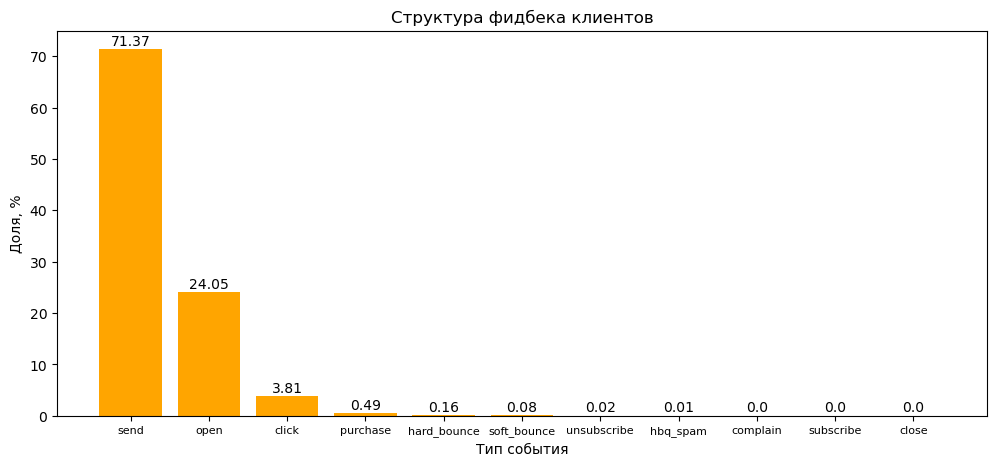

In [34]:
# столбчатый график
plt.figure(figsize=(12, 5))
bar_chart = plt.bar(messages_sum_table.index, messages_sum_table['доля, %'], color='orange')

#подписи
for bar in bar_chart:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Тип события')
plt.xticks(fontsize=8)
plt.ylabel('Доля, %')
plt.title('Структура фидбека клиентов')
plt.show()

Распределение кампаний по типам используемых каналов - пуш на мобильный и электронная почта - практически поровну:

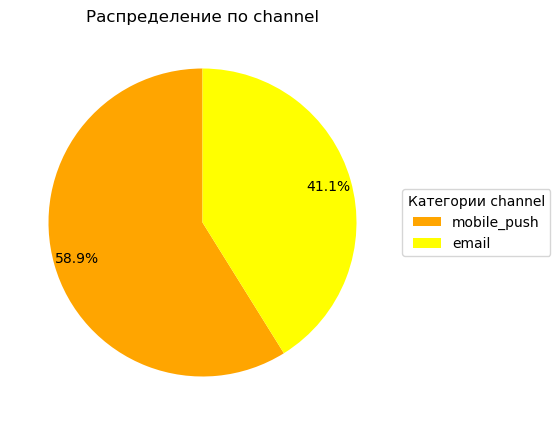

In [35]:
discrete_data_distribution (messages, 'channel')

Диапазон времени, за который у нас есть данные по рассылкам - messages['created_at'] - и в том числе и по полученному фидбеку от клиентов - messages['date'] - полностью совпадает между собой:

In [36]:
messages['date'].describe()

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

In [37]:
messages['created_at'].describe()

count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object

И практически аналогично совпадает диапазон времени в датасете покупок, с разницей всего лишь в несколько дней.

### Датасет target

In [38]:
target['target'].value_counts(normalize=True)

target
0    0.980722
1    0.019278
Name: proportion, dtype: float64

Здесь мы можем видеть, доля клиентов, которые покупали хоть что-то - составлет менее 2%. 
Имеем ярко выраженный дисбаланс классов.

Соответственно, нам понадобится сэмплинг при настройке модели прогнозирования.
Метрика у нас задана изначально ROC_AUC.
И, в принципе, она подходит для прогнозирования в случае большого дисбаланса между классами.

Уникальных клиентов в датасете с таргетом у нас 49_849 и это множество клиентов полностью совпадает с множеством клиентов из  датасета покупок:

In [39]:
len(target['client_id'].unique())

49849

In [40]:
len(set(target['client_id'].unique()) & set(purchases['client_id'].unique()))

49849

### Добавление новых признаков и преобразование исходных

Переходим к самому главному. 
Для построения модели, как было отмечено уже на этапе предобработки, структура входящих признаков для построения модели должна быть в разрезе клиентов, поскольку задача прогнозировасть состояние клиентов.

При этом структура имеющейся информации у нас НЕ В РАЗРЕЗЕ КЛИЕНТОВ. Следовательно нужно преобразовать исходные данные.

Тут есть два пути. 
1) Мы можем присоединить к датасету таргет ВСЮ имеющуюся информацию о покупках клиентов и их коммуникациях в рассылках. То есть например, присоединить все покупки к таргету, таким образом чтобы каждая покупка/характеристика покупки клиента была отдельным полем/столбцом (дата покупки, категория покупки на эту дату и т. д.)
Плюсы такого - используем всю информацию. Минусы - очень большие датафреймы.

2) Мы можем агрегировать имеющуюся исходную информацию для задачи - например взять средние показатели о покупках клиентов, или экстремумы/крайние наблюдения - например, данные о последней/предпоследней покупке и т. п. 

Используем второй подход, поскольку, вряд ли имеет какое-либо влияние на вероятность покупки клиентом в ближайшее время то, что и когда он покупал ОТНОСИТЕЛЬНО ДАВНО год или, тем более, два года назад. 

Что именно мы можем сделать из тех данных что у нас есть:

1) у нас есть данные о датах покупок:
- мы можем рассчитать среднее время между покупками и добавить к этому дату последней покупки - если покупки носят регулярный характер у определенных клиентов, то они будут повторяться, если же покупки были давно и интервал времени между ними длинный - вероятность того, что этот клиент что-то купить, при прочих равных будет низкой;

2) у нас есть данные о ценах и количестве купленного:
- мы можем рассчитать общее количество покупок, общую выручку клиента, средний чек клиента - если клиенту нравится наш магазин и его сервис, то покупок будет несколько и средний чек у лояльных клиентов должен быть выше, чем у тех клиентов, которые попробовали и им не понравилось - они скорее всего остановятся на одной/двух покупках;

3) у нас есть категории товаров в покупках:
- мы можем взять категорию последней/предпоследней покупки в качестве входящего признака - если это был товар длительного пользования (принтер, например) - возможно клиент будет покупать к нему какие-либо расходники далее (картриджи к нему); если это была покупка из категории регулярно потребляемых товаров (там и были картриджи) - возможно это тоже ведет к повторению такого рода покупок (опять купит картридж или запчасть для его ремонта);

4) также у нас есть данные по сообщениям/фидбеку от клиента на рассылки:
- мы можем взять последнее/предпоследнее сообщение (event), если это был переход по ссылке или открытие - вероятность того, что такой клиент купит, может быть выше, чем у того, который просто получил или не получил вовсе.
- мы можем взять также и дату такого последнего сообщения - если у него и был клик, но он был давно - то вероятно покупки уже снижается, при прочих равных.

#### Среднее время между покупками

In [41]:
# добавление нового признака - среднее время между покупками

# группируем данные по клиентам и сортируем по дате
purchases = purchases.sort_values(by=['client_id', 'date'])

# вычисляем разницу во времени между покупками для каждого клиента
purchases['days_diff'] = purchases.groupby('client_id')['date'].diff().dt.days

In [42]:
# группируем данные из фрейма покупок клиентов по клиентам 
sum_table = purchases.pivot_table(index='client_id', values='days_diff', aggfunc='mean', dropna=False)
sum_table.columns = ['mean_time']

In [43]:
# объединяем полученные данные с таргетом
df = pd.merge(target, sum_table, on='client_id', how='left')
df.shape

(49849, 3)

In [44]:
# проверка пропусков после объединения
df.isna().sum()

client_id        0
target           0
mean_time    13195
dtype: int64

Как видим для практически трети клиентов среднее время между покупками не может быть вычислено - так как это единственная покупка.

Посмотрим распределение значений среднего времени между покупками:

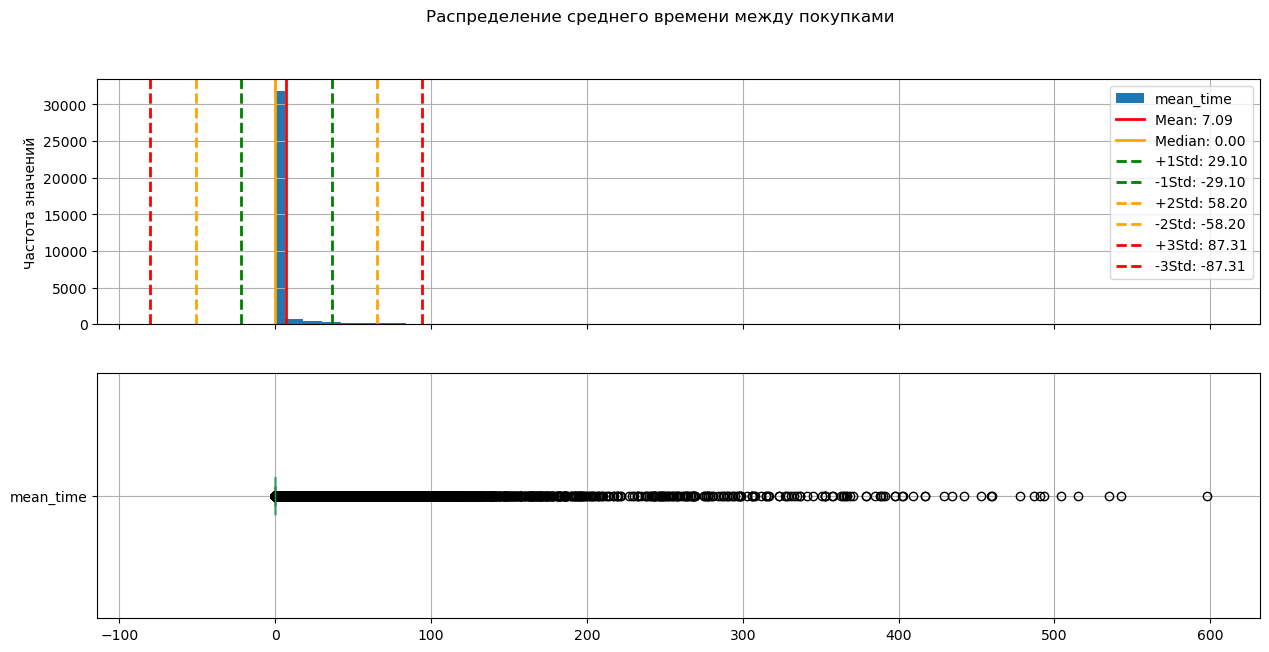

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [45]:
num_stat_description(df, 'mean_time', 100, 'Распределение среднего времени между покупками')

Здесь мы можем видеть, что у большинства клиентов - 43 тыс из 49 тыс всего, среднее время составляет ноль либо оно не может быть вычислено:

In [46]:
# количество клиентов с нулевым интервалом между покупками
df.query('mean_time == 0')['client_id'].count()

29511

In [47]:
# количество клиентов время между покупками для которых не может быть вычислено
df['mean_time'].isna().sum()

13195

Это означает что либо у них была одна покупка, либо было несколько покупок, но в один день, как мы видели ранее, таких клиентов очень много.

Клиентов, которые совершили 2 покупки и более (лояльные или условно-постоянные клиенты) - это более чем редкость для нашего магазина - это всего лишь 7 тыс клиентов или 14% от общего количества клиентов:

In [48]:
df.query('mean_time > 0')['client_id'].count()

7143

Что, очевидно не очень хорошо, так как если покупка делается один раз и не более, то:
- такой клиент скорее всего ушел, потому что ему не понравилось что-то;
- повторных покупок будет мало;
- прогнозировать повторные покупки будет крайне сложно, как и любое другое редкое событие;
- возможно, корневая проблема в решении вопроса как увеличить продажи нашего магазина не в том, кому и какие рассылки слать, а в другом - в продукте или сервисе, которые предлагет магазин, скорее всего.

Посмотрим распределение времени между покупками у условно-постоянных клиентов, кто сделал более 1 покупки в разные даты:

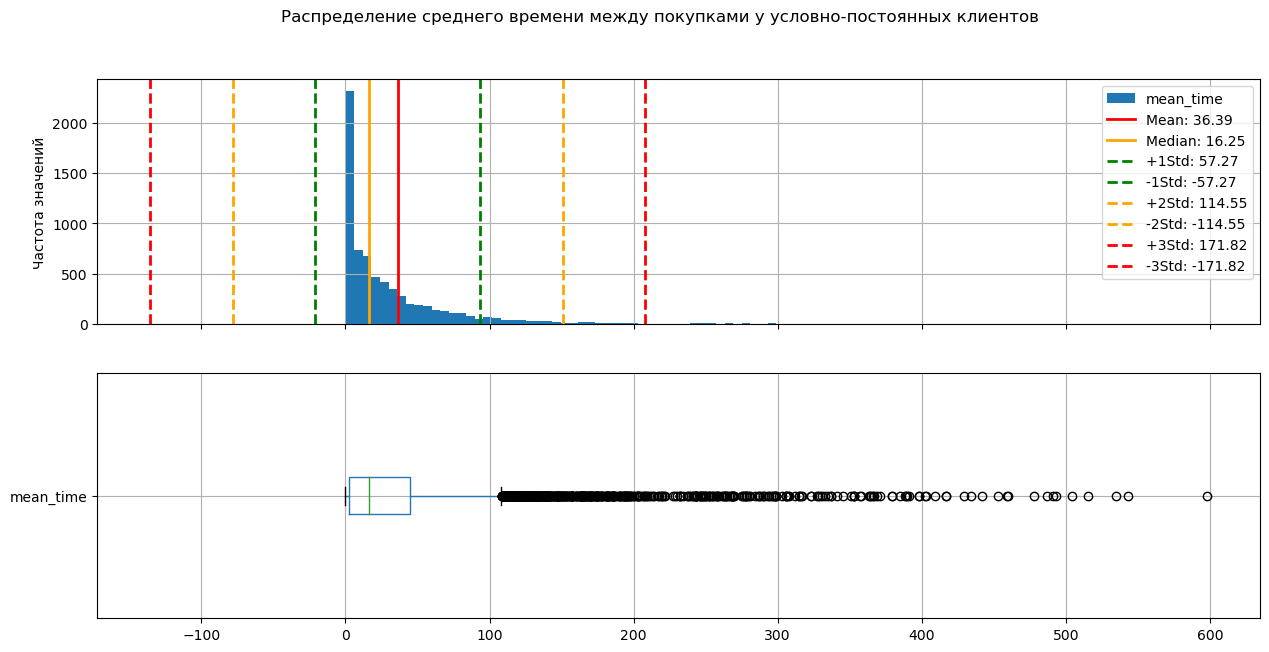

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [49]:
num_stat_description(df.query('mean_time > 0'), 'mean_time', 100, 
                     'Распределение среднего времени между покупками у условно-постоянных клиентов')

Здесь мы можем увидеть, что:
- среднее время между покупками условно-постоянных клиентов составляет 36 дней;
- стандартное отклоенение составляет 57 дней;
- выбросы начинаются от порядка 100.

Это говорит о том, что данная группа клиентов весьма вероятно хотя бы один раз совершает покупки как раз интервале 90 дней, что косвенно еще раз подтверждает что, количество покупок (и особенно если их 2 и более) и как давно была сделана покупка - также может служить предиктором для нашего таргета.

Теперь проведем тест на статистическую значимость среднего времени между покупками: 
- у клиентов, которые будут покупать ближайшие 90 дней (1 в нашем таргете); 
- и которые не будут ничего покупать в ближайшие 90 дней (0 в нашем таргете).

Поскольку данные среднего времени между покупками не распределены нормально, будем использовать тест Манна-Уитни:

In [50]:
# пользовательская функция для вывода результатов теста Манна-Уитни
def MWtest (dataset, feature, alpha):

    stat, p = mannwhitneyu(
        dataset.query('target == 1')[feature], 
        dataset.query('target == 0')[feature]
    )

    print('Статистика U:', stat)
    print('p-значение:', p)

    if p < alpha:
        print('Есть статистически значимые различия (отвергаем нулевую гипотезу)')
    else:
        print('Нет статистически значимых различий (не отвергаем нулевую гипотезу)')

In [51]:
# заполним пропуски, чтобы тест отработал корректно
df_copy = df.fillna(value=-1)
# тест
MWtest (df_copy, feature='mean_time', alpha=0.01)

Статистика U: 30181794.5
p-значение: 2.0158548971383247e-66
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Можем сделать вывод, что среднее время между покупками имеет статистически значимое влияние на вероятность покупки клиентом в следующие 90 дней, и следовательно, имеет смысл включить данный признак в будущую модель.

In [52]:
who_will_buy = round(np.mean(df.query('target == 1')['mean_time']), 2)
who_wont_buy = round(np.mean(df.query('target == 0')['mean_time']), 2)

print(f'Среднее время между покупками у клиентов, которые СОВЕРШАТ покупки в ближашие 90 дней: {who_will_buy} дней')        
print(f'Среднее время между покупками у клиентов, которые НЕ СОВЕРШАТ покупки в ближашие 90 дней: {who_wont_buy} дней')

Среднее время между покупками у клиентов, которые СОВЕРШАТ покупки в ближашие 90 дней: 14.82 дней
Среднее время между покупками у клиентов, которые НЕ СОВЕРШАТ покупки в ближашие 90 дней: 6.91 дней


#### Общее количество покупок у клиента, объем покупок клиента, средний чек клиента

Теперь вернемся к количеству покупок непосредственно. 

Выше мы уже отмечали, что: 
- группа клиентов, которая совершила покупки в ближайшие 90 дней, обычно имеет в своем опыте 2 и более покупок, в то время как подавляющее большинство из тех, кто не совершал покупки в ближайшие 90 дней имели чаще всего одну покупку (или несколько, но в рамках одного дня.

Выделим этот признак - количество покупок и проверим нашу гипотезу с помощью статистического теста аналогично.

In [53]:
# подсчет количества покупок в исходном фрейме
sum_table = purchases.pivot_table(index='client_id', values='quantity', aggfunc='sum') 
# добавление количества покупок к фрейму со входящими признаками для модели
df = pd.merge(df, sum_table, on='client_id', how='left')

In [54]:
df

,client_id,target,mean_time,quantity
0,1515915625468060902,0,0.000000,7
1,1515915625468061003,1,0.000000,7
2,1515915625468061099,0,NaN,1
3,1515915625468061100,0,0.000000,2
4,1515915625468061170,0,4.611111,19
...,...,...,...,...
49844,1515915626010261344,0,0.000000,6
49845,1515915626010266132,0,0.000000,2
49846,1515915626010439406,0,0.000000,2
49847,1515915626010443527,0,NaN,1


In [55]:
df.query('quantity == 1')['client_id'].count()

13047

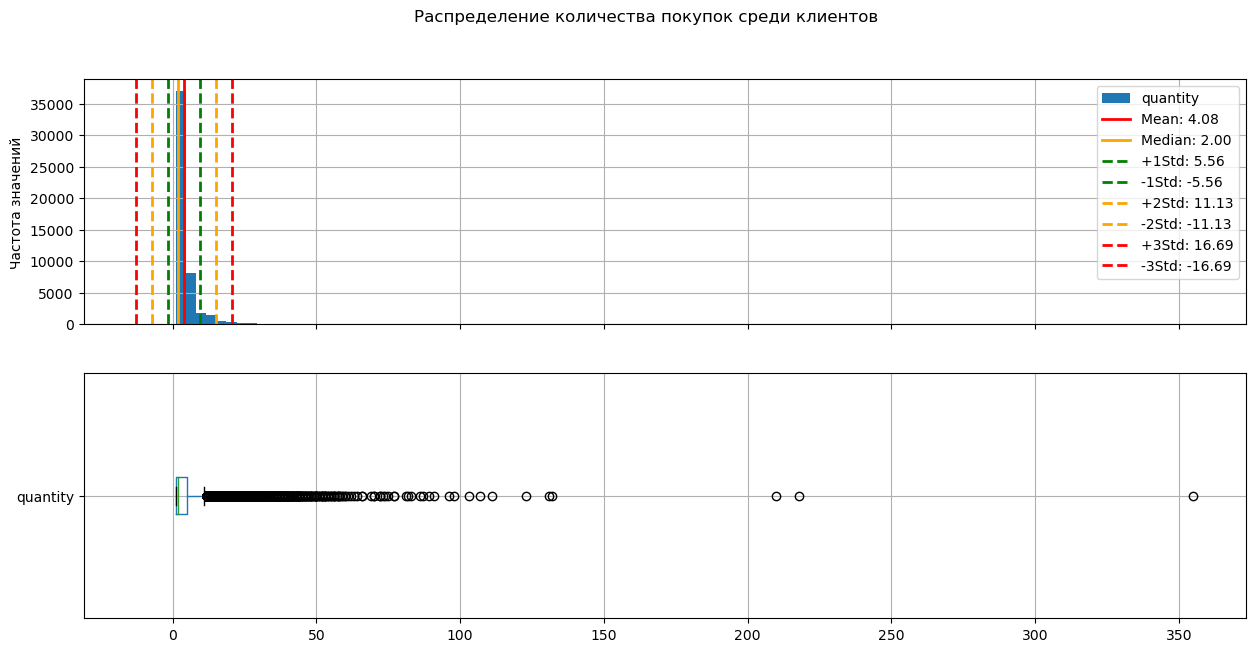

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [56]:
# анализ количества покупок в разрезе клиентов
num_stat_description(df, 'quantity', 100, 
                     'Распределение количества покупок среди клиентов')

Здесь мы можем видеть, что:
- распределение несимметричное, медиана - 2 покупки, среднее - 4 покупки;
- стандартное отклонение - 16 покупок;
- выбросы, если смотреть свечу - начинаются уже с 10 покупок;
- данные не распределены нормально.

В общем, не покупают часто - 4 покупки в среднем за 2 года, это 1 покупка за полгода в среднем. 
Еще раз наглядно видно, что цель нашего поиска - кто купит в ближайшие 90 дней - редкое явление.

Проведем тест на статистическую значимость этого признака для таргета:

In [57]:
MWtest (df, feature='quantity', alpha=0.01)

Статистика U: 30073306.5
p-значение: 2.48545121756132e-52
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Наша гипотеза подтвердилась, признак имеет статистическую значимость - имеет смысл включить его в модель.

In [58]:
who_will_buy = round(np.mean(df.query('target == 1')['quantity']), 2)
who_wont_buy = round(np.mean(df.query('target == 0')['quantity']), 2)

print(f'Среднее количество покупок у клиентов, \
которые СОВЕРШАТ покупки в ближашие 90 дней: {who_will_buy} покупок')        

print(f'Среднее количество покупок у клиентов, \
которые НЕ СОВЕРШАТ покупки в ближашие 90 дней: {who_wont_buy} покупок')

Среднее количество покупок у клиентов, которые СОВЕРШАТ покупки в ближашие 90 дней: 7.12 покупок
Среднее количество покупок у клиентов, которые НЕ СОВЕРШАТ покупки в ближашие 90 дней: 4.02 покупок


Как можем видеть еще и наглядно, помимо теста, покупатели которые сделали 4 покупки за период наблюдения (2 года) или которые делают по сути покупку раз в полгода, СКОРЕЕ ВСЕГО относятся к нецелевой группе нашего исследования - они НЕ КУПЯТ в ближайшие 90 дней.

А покупатели, которые сделали 7 покупок за период наблюдения как раз близки к показателю одна покупка в квартал (90 дней).

Далее.

Также мы можем еще добавить такие признаки как объем выручки (у нас есть и цены, и количество) и средний чек покупателя:

In [59]:
purchases ['rev'] = purchases['quantity'] * purchases ['price']

sum_table = purchases.pivot_table(index='client_id', values='rev', aggfunc='sum')

# добавление выручки покупок к фрейму со входящими признаками для модели
df = pd.merge(df, sum_table, on='client_id', how='left')

# проверка объединения
df.shape

(49849, 5)

In [60]:
# проверка пропусков после объединения
df.isna().sum()

client_id        0
target           0
mean_time    13195
quantity         0
rev              0
dtype: int64

In [61]:
# расчет среднего чека 
df['av_bill'] = df ['rev'] / df ['quantity']

In [62]:
MWtest (df, feature='rev', alpha=0.01)

Статистика U: 26058966.0
p-значение: 6.108716257804994e-09
Есть статистически значимые различия (отвергаем нулевую гипотезу)


In [63]:
MWtest (df, feature='av_bill', alpha=0.01)

Статистика U: 19249739.5
p-значение: 7.91861881797284e-22
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Как видим все три признака имеют статистическую значимость, и могут быть включены в модель, единственное, что стоит отметить - все три данных признака имеют одинаковую природу (чем больше количество покупок, тем больше выручка, к примеру) и скорее всего достаточно будет одного, включение остальных, вероятно, не будет влиять на улучшение качества будущей модели.

#### Даты последних покупок

In [64]:
# добавим еще один признак - даты трех последних покупок

# cортируем данные по client_id и date в обратном порядке
purchases = purchases.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последние 3 покупки для каждого клиента (топ-3 по дате убывания)
purchases_top3 = purchases.groupby('client_id').head(3)

# создаем новый DataFrame с датами последних покупок в отдельных столбцах
purchases_top3 = purchases_top3.groupby('client_id')['date'].apply(lambda x: x.reset_index(drop=True)
                                                                  ).unstack().rename(columns=lambda x: f'last_purchase_{x+1}')

# задаем значение с крайней датой, от которой будем считать количество прошедших дней
purchases_top3['date_border'] = purchases['date'].max()

# вычисляем количество прошедших дней с момента последних трех покупок
purchases_top3['days_after_purch_1'] = (purchases_top3['date_border'] - purchases_top3['last_purchase_1']).dt.days
purchases_top3['days_after_purch_2'] = (purchases_top3['date_border'] - purchases_top3['last_purchase_2']).dt.days
purchases_top3['days_after_purch_3'] = (purchases_top3['date_border'] - purchases_top3['last_purchase_3']).dt.days

In [65]:
# добавляем время прошедшее с момента трех последних покупок к фрейму со входящими признаками для модели
df = pd.merge(df, purchases_top3[['days_after_purch_1', 'days_after_purch_2', 'days_after_purch_3']], 
              how='left', on='client_id')

# проверка объединения
df.shape

(49849, 9)

In [66]:
df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN


In [67]:
# проверка пропусков после объединения
df.isna().sum()

client_id                 0
target                    0
mean_time             13195
quantity                  0
rev                       0
av_bill                   0
days_after_purch_1        0
days_after_purch_2    13195
days_after_purch_3    27028
dtype: int64

In [68]:
# тест на статзначимость призанка - количество прошедших дней после последней покупки
MWtest (df, feature='days_after_purch_1', alpha=0.01)

Статистика U: 16402654.0
p-значение: 6.238249520940552e-58
Есть статистически значимые различия (отвергаем нулевую гипотезу)


In [69]:
# тест на статзначимость призанка - количество прошедших дней после предпоследней покупки

# чтобы тест отработал корректно заполним пропуски значением (720 дней - максимальный период наблюдения 2 года)
df_copy = df.fillna(value=720)
MWtest (df_copy, feature='days_after_purch_2', alpha=0.01)

Статистика U: 16239109.5
p-значение: 1.1672991587397906e-61
Есть статистически значимые различия (отвергаем нулевую гипотезу)


In [70]:
# тест на статзначимость призанка - количество прошедших дней после предпредпоследней покупки

MWtest (df_copy, feature='days_after_purch_3', alpha=0.01)

Статистика U: 17683782.5
p-значение: 1.2933402792086288e-46
Есть статистически значимые различия (отвергаем нулевую гипотезу)


Аналогично, все три данных признака могут быть включены, исходя из данных теста в будущую модель.

**Промежуточный вывод:**

На текущий момент у нас получается следуюшая механика прогноза (весьма простая):
- имеет влияние среднее время между покупками;
- имеет влияние время - как давно была последняя покупка (и предыдущие покупки);
- имеет влияние количество покупок и производные от нее - выручка клиента, средний чек клиента.

По сути, если у клиента несколько покупок (2 и более), мы с определенной вероятностью можем ожидать повторения покупок (гораздо более высокой, чем у клиента, который сделал только одну покупку за историю в 2 года). И добавляя к дате последней покупки среднее время между покупками - можем понять дату следующей - а значит понять будет ли он покупать в следующие 90 дней. И, логично, что чем больше у него покупок - тем надежнее прогноз по нему, при прочих равных.

#### Категории последних трех покупок

Вернемся обратно к рассуждению о возможных входящих признаках для нашей модели. 
В п.3 у нас была следующая гипотеза:

- мы можем взять категорию последней/предпоследней покупки в качестве входящего признака - если это был товар длительного пользования (принтер, например) - (1) возможно клиент будет покупать к нему какие-либо расходники далее (картриджи к нему); если это была покупка из категории регулярно потребляемых товаров (там и были картриджи) - (2) возможно это тоже ведет к повторению такого рода покупок (опять купит картридж или же запчасть для его ремонта).

Также мы можем добавить не только конкретные значения категорий, но и расстояния между ними, используя идею, что значения категорий мы можем представить как точки в многомерном пространстве.

Тогда модель будет искать не только конретные паттерны, но и похожие - например, купил картридж с синей краской - в следующий раз купить с красной, например. У таких товаров будут немного разные значения категорий, в последнем элементе должны быть отличия, и расстояние между ними будет условно небольшим. 

In [71]:
# добавляем еще один признак - категория последних 3 покупок

# сортируем данные по client_id и date в обратном порядке
purchases = purchases.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последние 3 покупки для каждого клиента по дате
purchases_top3 = purchases.groupby('client_id').head(3)

# cоздаем новый DataFrame с категориями 3 последних покупок в отдельных столбцах
purchases_top3 = purchases_top3.groupby('client_id')['category_ids'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'category_last_purch_{x+1}')


In [72]:
# результат - категории трех последних покупок по каждому клиенту
purchases_top3.head(3)

,category_last_purch_1,category_last_purch_2,category_last_purch_3
client_id,,,
1515915625468060902,"['4', '27', '176', '458']","['4', '28', '260', '420']","['4', '27', '1828', '1599']"
1515915625468061003,"['4', '28', '249', '615']","['4', '28', '249', '615']","['4', '28', '249', '615']"
1515915625468061099,"['4', '28', '290', '424']",NaN,NaN


In [73]:
# пользовательская функция для обработки списков в настоящие списки
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

In [74]:
# пользовательская функция для разрезания списков на отдельные элемнты в отдельные столбцы
def list_cut (df, column, n):
    
    # преобразуем значения category_ids в настоящие списки с помощью def safe_literal_eval
    df[column] = df[column].apply(safe_literal_eval)

    # разрежем списки на отдельные элементы
    values_df = df[column].apply(pd.Series)

    # приведем полученные значения к числовому типу
    values_df = values_df.apply(pd.to_numeric, errors='coerce')

    # дадим наименования столбцам с отдельными элементами
    values_df = values_df.rename(columns=lambda x: f'last_purch_{n}_cat_level_{x+1}')

    # добавим новые столбцы к первоначальному датафрейму
    df = pd.concat([df, values_df], axis=1)
    
    return df

In [75]:
# разрежем на отдельные элементы списки, которые обозначают категории 3 последних покупок

purchases_top3 = list_cut (purchases_top3, 'category_last_purch_1', 1)
purchases_top3 = list_cut (purchases_top3, 'category_last_purch_2', 2)
purchases_top3 = list_cut (purchases_top3, 'category_last_purch_2', 3)

In [76]:
# результат - категории трех последних покупок - разрезанные на отдельные элементы
purchases_top3.head(3)

,category_last_purch_1,category_last_purch_2,category_last_purch_3,last_purch_1_cat_level_1,last_purch_1_cat_level_2,last_purch_1_cat_level_3,last_purch_1_cat_level_4,last_purch_1_cat_level_5,last_purch_2_cat_level_1,last_purch_2_cat_level_2,last_purch_2_cat_level_3,last_purch_2_cat_level_4,last_purch_2_cat_level_5,last_purch_3_cat_level_1,last_purch_3_cat_level_2,last_purch_3_cat_level_3,last_purch_3_cat_level_4,last_purch_3_cat_level_5
client_id,,,,,,,,,,,,,,,,,,
1515915625468060902,"[4, 27, 176, 458]","[4, 28, 260, 420]","['4', '27', '1828', '1599']",4.0,27.0,176.0,458.0,NaN,4.0,28.0,260.0,420.0,NaN,4.0,28.0,260.0,420.0,NaN
1515915625468061003,"[4, 28, 249, 615]","[4, 28, 249, 615]","['4', '28', '249', '615']",4.0,28.0,249.0,615.0,NaN,4.0,28.0,249.0,615.0,NaN,4.0,28.0,249.0,615.0,NaN
1515915625468061099,"[4, 28, 290, 424]",NaN,NaN,4.0,28.0,290.0,424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# добавляем категории трех последних покупок в поэлементном разрезе к фрейму со входящими признаками для модели
df = pd.merge(df, purchases_top3[[
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_1_cat_level_5',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_2_cat_level_5',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'last_purch_3_cat_level_5']], 
              how='left', on='client_id')

# проверка объединения
df.shape

(49849, 24)

In [78]:
# результат объединения
df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,last_purch_2_cat_level_1,last_purch_2_cat_level_2,last_purch_2_cat_level_3,last_purch_2_cat_level_4,last_purch_2_cat_level_5,last_purch_3_cat_level_1,last_purch_3_cat_level_2,last_purch_3_cat_level_3,last_purch_3_cat_level_4,last_purch_3_cat_level_5
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,4.0,28.0,260.0,420.0,NaN,4.0,28.0,260.0,420.0,NaN
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,4.0,28.0,249.0,615.0,NaN,4.0,28.0,249.0,615.0,NaN
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# проверка наличия пропусков
df.isna().sum()

client_id                       0
target                          0
mean_time                   13195
quantity                        0
rev                             0
av_bill                         0
days_after_purch_1              0
days_after_purch_2          13195
days_after_purch_3          27028
last_purch_1_cat_level_1     1755
last_purch_1_cat_level_2     1755
last_purch_1_cat_level_3     1755
last_purch_1_cat_level_4     2055
last_purch_1_cat_level_5    49650
last_purch_2_cat_level_1    15046
last_purch_2_cat_level_2    15046
last_purch_2_cat_level_3    15046
last_purch_2_cat_level_4    15318
last_purch_2_cat_level_5    49713
last_purch_3_cat_level_1    15046
last_purch_3_cat_level_2    15046
last_purch_3_cat_level_3    15046
last_purch_3_cat_level_4    15318
last_purch_3_cat_level_5    49713
dtype: int64

Здесь мы можем видеть, что у нас есть пропуски на 1-4 уровне иерархии - они не всегда используются, по всей видимости.
И очень редко используется в 5 уровень ирерархии. Вероятнее всего, именно 5 уровень будет иметь низкую прогностическую мощность по этой причине.

In [80]:
# заполним пропуски, чтобы тест Манна-Уитни корректно отработал

df[[
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_1_cat_level_5',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_2_cat_level_5',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'last_purch_3_cat_level_5']] = df[[
                                     'last_purch_1_cat_level_1',
                                     'last_purch_1_cat_level_2',
                                     'last_purch_1_cat_level_3',
                                     'last_purch_1_cat_level_4',
                                     'last_purch_1_cat_level_5',
                                     'last_purch_2_cat_level_1',
                                     'last_purch_2_cat_level_2',
                                     'last_purch_2_cat_level_3',
                                     'last_purch_2_cat_level_4',
                                     'last_purch_2_cat_level_5',
                                     'last_purch_3_cat_level_1',
                                     'last_purch_3_cat_level_2',
                                     'last_purch_3_cat_level_3',
                                     'last_purch_3_cat_level_4',
                                     'last_purch_3_cat_level_5']].fillna(value=-1)

In [81]:
# тест Манна-Уитни на статистическую значимость признаков
# а именно - категории последних трех покупок в разрезе уровней иерархии

subset_of_features = [
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_1_cat_level_5',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_2_cat_level_5',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'last_purch_3_cat_level_5'
]

for feature in subset_of_features:
    print (feature)
    MWtest(df, feature=feature, alpha=0.01)
    print('')


last_purch_1_cat_level_1
Статистика U: 24100703.0
p-значение: 0.11932703475137497
Нет статистически значимых различий (не отвергаем нулевую гипотезу)

last_purch_1_cat_level_2
Статистика U: 24005512.0
p-значение: 0.2227305681768348
Нет статистически значимых различий (не отвергаем нулевую гипотезу)

last_purch_1_cat_level_3
Статистика U: 23771208.0
p-значение: 0.5252845152026364
Нет статистически значимых различий (не отвергаем нулевую гипотезу)

last_purch_1_cat_level_4
Статистика U: 24735673.0
p-значение: 0.004820099585385382
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_purch_1_cat_level_5
Статистика U: 23469838.0
p-значение: 0.6657172360783843
Нет статистически значимых различий (не отвергаем нулевую гипотезу)

last_purch_2_cat_level_1
Статистика U: 27380122.5
p-значение: 1.3970405817371376e-20
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_purch_2_cat_level_2
Статистика U: 27377191.5
p-значение: 1.4129374202841292e-19
Есть статист

Здесь мы можем видеть, что статистическую значимость имеет значение:
- для последней покупки (last_purch_1) - только 4 уровень;
- для предпоследней покупки (last_purch_2) - все уровни с 1 по 4;
- для предпредпоследней покупки ((last_purch_3) - также все уровни с 1 по 4.
                                 
Можно понять почему не значат верхние уровни (с 1 по 3) для последней покупки, скорее всего на верхних уровнях часто повторяются одни и те же значения, и никаких значимых изменений соответственно нет между целевой группой и нецелевой.

Но, с другой стороны, понять, почему они, НАОБОРОТ, уже могут иметь значение в last_purch_2 и last_purch_3 - здесь уже сложно с гипотезами. Разве что, ДЕЙСТВИТЕЛЬНО, в целевой и нецелевой группе действительно на предпоследней и предпредпоследней покупке встречаются РАЗНЫЕ категории, даже на 1-3 уровне. Значит есть какие-то паттерны, отличающие целевые группы (кто сделает покупку в следующие 90 дней и кто не сделает) по предпоследней и предпредпоследней покупке.

#### Расстояние или подобие между категориями последних покупок

In [82]:
# теперь объединим элементы, описывающие категории в один вектор для каждой покупки - три последние покупки клиента

df['vector_category_purch_1'] = df.apply(lambda row: np.array(
    [row['last_purch_1_cat_level_1'], 
     row['last_purch_1_cat_level_2'], 
     row['last_purch_1_cat_level_3'], 
     row['last_purch_1_cat_level_4']]), 
                                         axis=1)

df['vector_category_purch_2'] = df.apply(lambda row: np.array(
    [row['last_purch_2_cat_level_1'], 
     row['last_purch_2_cat_level_2'], 
     row['last_purch_2_cat_level_3'], 
     row['last_purch_2_cat_level_4']]), 
                                         axis=1)

df['vector_category_purch_3'] = df.apply(lambda row: np.array(
    [row['last_purch_3_cat_level_1'], 
     row['last_purch_3_cat_level_2'], 
     row['last_purch_3_cat_level_3'], 
     row['last_purch_3_cat_level_4']]), 
                                         axis=1)

In [83]:
# результат добавления 
df[[
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_1_cat_level_5',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_2_cat_level_5',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'last_purch_3_cat_level_5',

    'vector_category_purch_1',
    'vector_category_purch_2',
    'vector_category_purch_3'
]]

,last_purch_1_cat_level_1,last_purch_1_cat_level_2,last_purch_1_cat_level_3,last_purch_1_cat_level_4,last_purch_1_cat_level_5,last_purch_2_cat_level_1,last_purch_2_cat_level_2,last_purch_2_cat_level_3,last_purch_2_cat_level_4,last_purch_2_cat_level_5,last_purch_3_cat_level_1,last_purch_3_cat_level_2,last_purch_3_cat_level_3,last_purch_3_cat_level_4,last_purch_3_cat_level_5,vector_category_purch_1,vector_category_purch_2,vector_category_purch_3
0,4.0,27.0,176.0,458.0,-1.0,4.0,28.0,260.0,420.0,-1.0,4.0,28.0,260.0,420.0,-1.0,"[4.0, 27.0, 176.0, 458.0]","[4.0, 28.0, 260.0, 420.0]","[4.0, 28.0, 260.0, 420.0]"
1,4.0,28.0,249.0,615.0,-1.0,4.0,28.0,249.0,615.0,-1.0,4.0,28.0,249.0,615.0,-1.0,"[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]"
2,4.0,28.0,290.0,424.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,"[4.0, 28.0, 290.0, 424.0]","[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]"
3,4.0,27.0,1828.0,5717.0,-1.0,4.0,27.0,1828.0,5717.0,-1.0,4.0,27.0,1828.0,5717.0,-1.0,"[4.0, 27.0, 1828.0, 5717.0]","[4.0, 27.0, 1828.0, 5717.0]","[4.0, 27.0, 1828.0, 5717.0]"
4,4.0,28.0,244.0,432.0,-1.0,4.0,28.0,244.0,432.0,-1.0,4.0,28.0,244.0,432.0,-1.0,"[4.0, 28.0, 244.0, 432.0]","[4.0, 28.0, 244.0, 432.0]","[4.0, 28.0, 244.0, 432.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,2.0,18.0,212.0,726.0,-1.0,2.0,18.0,212.0,726.0,-1.0,2.0,18.0,212.0,726.0,-1.0,"[2.0, 18.0, 212.0, 726.0]","[2.0, 18.0, 212.0, 726.0]","[2.0, 18.0, 212.0, 726.0]"
49845,4.0,27.0,278.0,470.0,-1.0,4.0,27.0,278.0,470.0,-1.0,4.0,27.0,278.0,470.0,-1.0,"[4.0, 27.0, 278.0, 470.0]","[4.0, 27.0, 278.0, 470.0]","[4.0, 27.0, 278.0, 470.0]"
49846,4.0,27.0,233.0,462.0,-1.0,4.0,27.0,233.0,462.0,-1.0,4.0,27.0,233.0,462.0,-1.0,"[4.0, 27.0, 233.0, 462.0]","[4.0, 27.0, 233.0, 462.0]","[4.0, 27.0, 233.0, 462.0]"
49847,2.0,18.0,274.0,446.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,"[2.0, 18.0, 274.0, 446.0]","[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]"


In [84]:
# пользовательская функция для расчета евклидова расстояния 
def calculate_distance(df, col1, col2):
    def distance(row):
        point1 = np.array(row[col1])
        point2 = np.array(row[col2])
        return np.linalg.norm(point1 - point2)
    
    # Применение функции к DataFrame
    distances = df.apply(distance, axis=1)
    return distances

In [85]:
# добавим новые признаки - расстояния между покупками в пространстве категорий
df['distance_1_2'] = calculate_distance(df, 'vector_category_purch_1', 'vector_category_purch_2')
df['distance_3_2'] = calculate_distance(df, 'vector_category_purch_2', 'vector_category_purch_3')

In [86]:
df

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,last_purch_3_cat_level_1,last_purch_3_cat_level_2,last_purch_3_cat_level_3,last_purch_3_cat_level_4,last_purch_3_cat_level_5,vector_category_purch_1,vector_category_purch_2,vector_category_purch_3,distance_1_2,distance_3_2
0,1515915625468060902,0,0.000000,7,6993.0,999.000000,630,630.0,630.0,4.0,...,4.0,28.0,260.0,420.0,-1.0,"[4.0, 27.0, 176.0, 458.0]","[4.0, 28.0, 260.0, 420.0]","[4.0, 28.0, 260.0, 420.0]",92.200868,0.0
1,1515915625468061003,1,0.000000,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,4.0,28.0,249.0,615.0,-1.0,"[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]",0.000000,0.0
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,"[4.0, 28.0, 290.0, 424.0]","[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]",515.918598,0.0
3,1515915625468061100,0,0.000000,2,2098.0,1049.000000,6,6.0,NaN,4.0,...,4.0,27.0,1828.0,5717.0,-1.0,"[4.0, 27.0, 1828.0, 5717.0]","[4.0, 27.0, 1828.0, 5717.0]","[4.0, 27.0, 1828.0, 5717.0]",0.000000,0.0
4,1515915625468061170,0,4.611111,19,33601.0,1768.473684,244,244.0,244.0,4.0,...,4.0,28.0,244.0,432.0,-1.0,"[4.0, 28.0, 244.0, 432.0]","[4.0, 28.0, 244.0, 432.0]","[4.0, 28.0, 244.0, 432.0]",0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,0.000000,6,8994.0,1499.000000,0,0.0,0.0,2.0,...,2.0,18.0,212.0,726.0,-1.0,"[2.0, 18.0, 212.0, 726.0]","[2.0, 18.0, 212.0, 726.0]","[2.0, 18.0, 212.0, 726.0]",0.000000,0.0
49845,1515915626010266132,0,0.000000,2,1818.0,909.000000,2,2.0,NaN,4.0,...,4.0,27.0,278.0,470.0,-1.0,"[4.0, 27.0, 278.0, 470.0]","[4.0, 27.0, 278.0, 470.0]","[4.0, 27.0, 278.0, 470.0]",0.000000,0.0
49846,1515915626010439406,0,0.000000,2,198.0,99.000000,0,0.0,NaN,4.0,...,4.0,27.0,233.0,462.0,-1.0,"[4.0, 27.0, 233.0, 462.0]","[4.0, 27.0, 233.0, 462.0]","[4.0, 27.0, 233.0, 462.0]",0.000000,0.0
49847,1515915626010443527,0,NaN,1,1999.0,1999.000000,0,NaN,NaN,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,"[2.0, 18.0, 274.0, 446.0]","[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]",525.170449,0.0


In [87]:
# тест Манна-Уитни на статическую значимость по показателю подобия - расстояния в многомерном пространстве между точками
# которые задаются категориями покупки; 

# подобие между последней и предпоследней покупкой

MWtest(df, 'distance_1_2', alpha=0.01)

Статистика U: 19955441.0
p-значение: 2.2941960714535523e-19
Есть статистически значимые различия (отвергаем нулевую гипотезу)


In [88]:
# тест Манна-Уитни на статическую значимость по показателю подобия - расстояния в многомерном пространстве между точками
# которые задаются категориями покупки; 

# подобие между предпоследней и предпредпоследней покупкой

MWtest(df, 'distance_3_2', alpha=0.01)

Статистика U: 23490684.0
p-значение: 1.0
Нет статистически значимых различий (не отвергаем нулевую гипотезу)


Как видим, статически значимой разницы по показателю расстояние (или подобие) между предпоследней и предпредпоследней покупкой у целевой и нецелевой группы нет.

А вот как раз между последней и предпоследней - есть. Поэтому этот признак тоже можем включить в модель.

Можно также отметить, что вероятность по последнему тесту у нас равна строго 1. 
Скорее всего это связано с тем, что практически все расстояния у нас в этом случае равны 0.

Проверим это:


In [89]:
df['distance_3_2'].describe()

count    49849.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: distance_3_2, dtype: float64

Собственно, так и есть.
Основная причина этого конечно не поведение покупателей в части выбора покупок, а тот факт, что у нас мало покупателей которые сделали более 2 покупок, и еще меньше, у кого 3 покупки. Соответственно все вектора в этом случае у нас одинаковы.

А у тех покупателей, которые имеют в своей истории более трех покупок, действительно покупки одинаковые:

In [90]:
df.query('quantity > 3')[['vector_category_purch_2', 'vector_category_purch_3', 'distance_3_2']]

,vector_category_purch_2,vector_category_purch_3,distance_3_2
0,"[4.0, 28.0, 260.0, 420.0]","[4.0, 28.0, 260.0, 420.0]",0.0
1,"[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]",0.0
4,"[4.0, 28.0, 244.0, 432.0]","[4.0, 28.0, 244.0, 432.0]",0.0
8,"[6060.0, 6058.0, 6065.0, 1848.0]","[6060.0, 6058.0, 6065.0, 1848.0]",0.0
9,"[4.0, 28.0, 275.0, 421.0]","[4.0, 28.0, 275.0, 421.0]",0.0
...,...,...,...
49827,"[4.0, 28.0, 275.0, 421.0]","[4.0, 28.0, 275.0, 421.0]",0.0
49833,"[2.0, 18.0, 217.0, 663.0]","[2.0, 18.0, 217.0, 663.0]",0.0
49835,"[2.0, 18.0, 267.0, 443.0]","[2.0, 18.0, 267.0, 443.0]",0.0
49838,"[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]",0.0


Паттерн поведения конечно интересный, но поскольку значения не отличаются между целевой и нецелевой группой - такой признак действительно не имеет никакой прогностической мощности.

#### Фидбек клиента на последнюю рассылку (перешел, посмотрел, положил в спам...)

In [91]:
# добавим признак - последнее действие клиента на рассылку - event

# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее последние 3 события по убыванию даты для каждого клиента
messages_top3 = messages.groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['event'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'last_action_{x+1}')

In [92]:
# результат
messages_top3.head(3)

,last_action_1,last_action_2,last_action_3
client_id,,,
1515915625468060902,send,open,unsubscribe
1515915625468061003,send,send,send
1515915625468061099,send,send,send


In [93]:
# добавляем в датафрейм со входящими признаками
df = pd.merge(df, messages_top3, how='left', on='client_id')
df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,last_purch_3_cat_level_4,last_purch_3_cat_level_5,vector_category_purch_1,vector_category_purch_2,vector_category_purch_3,distance_1_2,distance_3_2,last_action_1,last_action_2,last_action_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,420.0,-1.0,"[4.0, 27.0, 176.0, 458.0]","[4.0, 28.0, 260.0, 420.0]","[4.0, 28.0, 260.0, 420.0]",92.200868,0.0,send,open,unsubscribe
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,615.0,-1.0,"[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]",0.000000,0.0,send,send,send
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,-1.0,-1.0,"[4.0, 28.0, 290.0, 424.0]","[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]",515.918598,0.0,send,send,send


In [94]:
# тест Манна-Уитни на статистическую значимость последнего действия клиента на рассылку
# а также предпоследнего и предпредпоследнего

# закодируем значения фрейм с 'last_action_1' числовыми значениями и заполним пропуски, чтобы тест корректно отработал
df_copy = df[['target','last_action_1', 'last_action_2','last_action_3']]
df_copy = df_copy.fillna('other')


# инициализация OrdinalEncoder
encoder = OrdinalEncoder(categories=[
    ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                'other', 'send', 'open','click','subscribe','purchase'],
    
    ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                'other', 'send', 'open','click','subscribe','purchase'],

    ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                'other', 'send', 'open','click','subscribe','purchase']
])

# кодирование категориальных значений 
df_copy[['last_action_1', 'last_action_2','last_action_3']] = encoder.fit_transform(
    df_copy[['last_action_1', 'last_action_2','last_action_3']]
)

# тест
subset_of_features = ['last_action_1', 'last_action_2','last_action_3']
for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

last_action_1
Статистика U: 25187000.0
p-значение: 1.993663331378056e-07
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_action_2
Статистика U: 26967476.0
p-значение: 9.133863330801033e-19
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_action_3
Статистика U: 25612486.0
p-значение: 3.526461745797589e-10
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Как видно из проведенного теста, последние три события имеют статистическую значимость в разделении таргета.
Следовательно этот признак также может быть включен в будущую модель.

#### Время с момента последнего фидбека 

In [95]:
# добавим признак - как давно был последний фидбек(event) от клиента на рассылку

# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее действие для каждого клиента
messages_top3 = messages.groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['date'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'date_of_last_action_{x+1}')

messages_top3.head(3)

,date_of_last_action_1,date_of_last_action_2,date_of_last_action_3
client_id,,,
1515915625468060902,2024-01-19,2024-01-19,2024-01-19
1515915625468061003,2024-02-13,2024-02-13,2024-02-09
1515915625468061099,2024-02-13,2024-02-13,2024-02-09


In [96]:
# вычисляем сколько времени прошло с момента последнего события

messages_top3['date_border'] = messages['date'].max()
messages_top3['days_from_last_action_1'] = (messages_top3['date_border'] - messages_top3['date_of_last_action_1']).dt.days
messages_top3['days_from_last_action_2'] = (messages_top3['date_border'] - messages_top3['date_of_last_action_2']).dt.days
messages_top3['days_from_last_action_3'] = (messages_top3['date_border'] - messages_top3['date_of_last_action_3']).dt.days

messages_top3.head(3)

,date_of_last_action_1,date_of_last_action_2,date_of_last_action_3,date_border,days_from_last_action_1,days_from_last_action_2,days_from_last_action_3
client_id,,,,,,,
1515915625468060902,2024-01-19,2024-01-19,2024-01-19,2024-02-15,27,27.0,27.0
1515915625468061003,2024-02-13,2024-02-13,2024-02-09,2024-02-15,2,2.0,6.0
1515915625468061099,2024-02-13,2024-02-13,2024-02-09,2024-02-15,2,2.0,6.0


In [97]:
# добавляем в датафрейм со входящими признаками

df = pd.merge(df, messages_top3[['days_from_last_action_1', 'days_from_last_action_2','days_from_last_action_3']], how='left', on='client_id')
df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,vector_category_purch_2,vector_category_purch_3,distance_1_2,distance_3_2,last_action_1,last_action_2,last_action_3,days_from_last_action_1,days_from_last_action_2,days_from_last_action_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,"[4.0, 28.0, 260.0, 420.0]","[4.0, 28.0, 260.0, 420.0]",92.200868,0.0,send,open,unsubscribe,27.0,27.0,27.0
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,"[4.0, 28.0, 249.0, 615.0]","[4.0, 28.0, 249.0, 615.0]",0.000000,0.0,send,send,send,2.0,2.0,6.0
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,"[-1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0, -1.0]",515.918598,0.0,send,send,send,2.0,2.0,6.0


In [98]:
# тест Манна-Уитни по времени последнего события

# заполним пропуски чтобы тест корректно отработал
df_copy = df[['target','days_from_last_action_1', 'days_from_last_action_2','days_from_last_action_3']]
df_copy = df_copy.fillna(-1)

subset_of_features = ['days_from_last_action_1', 'days_from_last_action_2','days_from_last_action_3']
for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

days_from_last_action_1
Статистика U: 21440536.5
p-значение: 1.1805337257496771e-06
Есть статистически значимые различия (отвергаем нулевую гипотезу)

days_from_last_action_2
Статистика U: 21224887.5
p-значение: 1.7686150931594202e-07
Есть статистически значимые различия (отвергаем нулевую гипотезу)

days_from_last_action_3
Статистика U: 20009704.5
p-значение: 1.5103855008370598e-15
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Аналогично, время, относительно того как давно было последнее событие по рассылке также имеет значение.

#### Активный фидбек клиента на последнюю рассылку (click, переход по ссылке) 

In [99]:
# добавим признак - последнее активное действие (click, переход по ссылке)

# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее последние 3 события по убыванию даты для каждого клиента
messages_top3 = messages.query('event == "click"').groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['event'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'last_active_action_{x+1}')

In [100]:
messages_top3.head(3)

,last_active_action_1,last_active_action_2,last_active_action_3
client_id,,,
1515915625468060902,click,click,click
1515915625468061003,click,click,click
1515915625468061099,click,click,click


In [101]:
len(messages_top3.index.unique())

48060

In [102]:
df = pd.merge(df, messages_top3, how='left', on='client_id')
df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,distance_3_2,last_action_1,last_action_2,last_action_3,days_from_last_action_1,days_from_last_action_2,days_from_last_action_3,last_active_action_1,last_active_action_2,last_active_action_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,0.0,send,open,unsubscribe,27.0,27.0,27.0,click,click,click
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,0.0,send,send,send,2.0,2.0,6.0,click,click,click
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,0.0,send,send,send,2.0,2.0,6.0,click,click,click


In [103]:
# тест Манна-Уитни на статистическую значимость последнего действия клиента на рассылку
# а также предпоследнего и предпредпоследнего

# закодируем значения фрейм с 'last_action_1' числовыми значениями и заполним пропуски, чтобы тест корректно отработал
df_copy = df[['target','last_active_action_1', 'last_active_action_2','last_active_action_3']]
df_copy = df_copy.fillna('other')


# инициализация OrdinalEncoder
encoder = OrdinalEncoder()

# кодирование категориальных значений 
df_copy[['last_active_action_1', 'last_active_action_2','last_active_action_3']] = encoder.fit_transform(
    df_copy[['last_active_action_1', 'last_active_action_2','last_active_action_3']]
)

# тест
subset_of_features = ['last_active_action_1', 'last_active_action_2','last_active_action_3']
for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

last_active_action_1
Статистика U: 22186634.5
p-значение: 2.7221210245746894e-05
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_active_action_2
Статистика U: 21043183.0
p-значение: 1.488709639837566e-12
Есть статистически значимые различия (отвергаем нулевую гипотезу)

last_active_action_3
Статистика U: 20036009.0
p-значение: 5.657423497914037e-21
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Данный признак имеет, также статистическую значимость в разделении таргета.
Единственное отличие его от предыдущего - данный признак (был клик у клиента или нет по последним трем рассылкам) имеет меньше шума, чем предыдущий вариант.

#### Время с момента последнего активного фидбека (переход по ссылке)

In [104]:
# добавим признак - сколько времени прошло с момента последнего клика

# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее последние 3 события по убыванию даты для каждого клиента
messages_top3 = messages.query('event == "click"').groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['date'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'date_of_last_active_action_{x+1}')

In [105]:
messages_top3.head(3)

,date_of_last_active_action_1,date_of_last_active_action_2,date_of_last_active_action_3
client_id,,,
1515915625468060902,2024-01-06,2024-01-03,2022-11-07
1515915625468061003,2023-11-21,2023-05-16,2023-05-16
1515915625468061099,2023-08-28,2023-06-16,2023-02-08


In [106]:
# вычислим время с момента последнего клика

messages_top3['date_border'] = messages['date'].max()

messages_top3['days_from_last_active_action_1'] = (
    messages_top3['date_border'] - messages_top3['date_of_last_active_action_1']).dt.days

messages_top3['days_from_last_active_action_2'] = (
    messages_top3['date_border'] - messages_top3['date_of_last_active_action_2']).dt.days

messages_top3['days_from_last_active_action_3'] = (
    messages_top3['date_border'] - messages_top3['date_of_last_active_action_3']).dt.days

messages_top3.head(3)

,date_of_last_active_action_1,date_of_last_active_action_2,date_of_last_active_action_3,date_border,days_from_last_active_action_1,days_from_last_active_action_2,days_from_last_active_action_3
client_id,,,,,,,
1515915625468060902,2024-01-06,2024-01-03,2022-11-07,2024-02-15,40,43.0,465.0
1515915625468061003,2023-11-21,2023-05-16,2023-05-16,2024-02-15,86,275.0,275.0
1515915625468061099,2023-08-28,2023-06-16,2023-02-08,2024-02-15,171,244.0,372.0


In [107]:
# добавим во фрейм со входящими признаками 

df = pd.merge(df, messages_top3[
    ['days_from_last_active_action_1', 'days_from_last_active_action_2', 'days_from_last_active_action_3']
                                    ], how='left', on='client_id')

df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,last_action_3,days_from_last_action_1,days_from_last_action_2,days_from_last_action_3,last_active_action_1,last_active_action_2,last_active_action_3,days_from_last_active_action_1,days_from_last_active_action_2,days_from_last_active_action_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,unsubscribe,27.0,27.0,27.0,click,click,click,40.0,43.0,465.0
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,send,2.0,2.0,6.0,click,click,click,86.0,275.0,275.0
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,send,2.0,2.0,6.0,click,click,click,171.0,244.0,372.0


In [108]:
# тест Манна-Уитни по времени последнего события

# заполним пропуски чтобы тест корректно отработал
df_copy = df[['target','days_from_last_active_action_1', 'days_from_last_active_action_2', 'days_from_last_active_action_3']]
df_copy = df_copy.fillna(-1)

subset_of_features = ['days_from_last_active_action_1', 'days_from_last_active_action_2', 'days_from_last_active_action_3']
for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

days_from_last_active_action_1
Статистика U: 17546530.5
p-значение: 1.249505358494401e-41
Есть статистически значимые различия (отвергаем нулевую гипотезу)

days_from_last_active_action_2
Статистика U: 19848310.5
p-значение: 7.220733740301009e-17
Есть статистически значимые различия (отвергаем нулевую гипотезу)

days_from_last_active_action_3
Статистика U: 22126859.0
p-значение: 0.0015621921551697592
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Данный признак также может быть включен в модель.

**Промежуточные выводы на данном этапе:**

Ранее мы уже определили, что на таргет имеет очевидное влияние следующие факторы:
- среднее время между покупками;
- как давно была последняя покупка (и предыдущие покупки);
- количество покупок и производные от нее - выручка клиента, средний чек клиента.

На данном этапе, мы можем к этому списку также добавить:
- категории последних 3 покупок (что покупали);
- подобие между последней и предпоследней покупкой;
- последние 3 события/действия по рассылке;
- как давно были последние три события/действия по рассылке.

### Датасеты full_campaign_daily_event и full_campaign_daily_event_channel

Теперь вернемся к изучению оставшихся датасетов:
- full_campaign_daily_event 
- full_campaign_daily_event_channel

Если проанализировать их структуру, то из них можно почерпнуть информацию об эффективности рассылок в целом:
- какова конверсия в продажи;
- какова конверсия открытий в переходы по ссылками и т. д.

Отличие между ними, только в том, что последний добавляет срез по каналам, но при этом можно увидеть, что рассылки не бывают смешанными, и идут в одном определенном канале.

Исходя из этого, можем добавить еще следующие входящие признаки:
- конверсия рассылки, которая будет давать дополнительную информацию модели, если был клик, то насколько эффективность рассылки будет показывать насколько вероятен его трансформация в продажу, например;
- в каком канале клиент чаще откликается, и в каком канале идет последняя (или три последние) рассылки;

#### Эффективность рассылок

In [109]:
# рассчитаем эффективность рассылок - конверсия в продажи, click-to-rate

sum_table_campaign = full_campaign_daily_event.pivot_table(
    index='bulk_campaign_id', values=['count_send', 'count_click', 'count_purchase'], aggfunc='sum')

sum_table_campaign ['ctr'] = sum_table_campaign ['count_click'] / sum_table_campaign ['count_send'] *100
sum_table_campaign ['conversion'] = sum_table_campaign ['count_purchase'] / sum_table_campaign ['count_click'] * 100 

sum_table_campaign

,count_click,count_purchase,count_send,ctr,conversion
bulk_campaign_id,,,,,
548,0,0,0,NaN,NaN
563,37,1,0,inf,2.702703
577,0,0,0,NaN,NaN
585,9,0,0,inf,0.000000
594,2,0,0,inf,0.000000
...,...,...,...,...,...
15146,18322,21,811257,2.258470,0.114616
15147,11146,31,659127,1.691025,0.278127
15148,12829,15,3585351,0.357817,0.116923


In [110]:
# Замена значений inf на NaN
sum_table_campaign.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаление строк с NaN
sum_table_campaign = sum_table_campaign.dropna()

sum_table_campaign

,count_click,count_purchase,count_send,ctr,conversion
bulk_campaign_id,,,,,
4463,6986,80,467884,1.493105,1.145147
4488,30,3,1674,1.792115,10.000000
4489,15,0,748,2.005348,0.000000
4492,49989,1050,1403952,3.560592,2.100462
4498,1231,39,270838,0.454515,3.168156
...,...,...,...,...,...
15146,18322,21,811257,2.258470,0.114616
15147,11146,31,659127,1.691025,0.278127
15148,12829,15,3585351,0.357817,0.116923


In [111]:
sum_table_campaign.shape

(2930, 5)

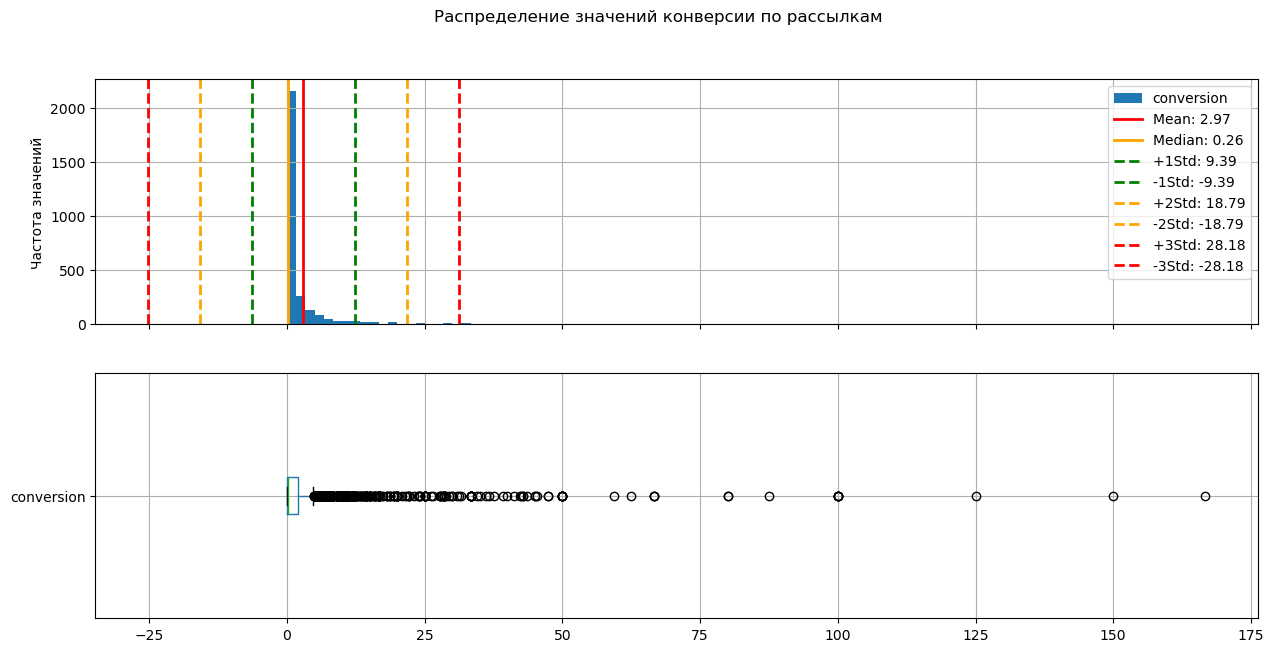

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [112]:
num_stat_description(sum_table_campaign, 'conversion', 100, 'Распределение значений конверсии по рассылкам')

Здесь мы можем видеть, что в среднем конверсия рассылок в продажи составляет почти 3%, стандартное отклонение - 9,4%.
Распределение выраженное несимметричное - половина всех рассылок проходит с конверсией 0,26% (медиана).


Есть аномальные значения - часть рассылок со значениями более 100% - это следует удалить.


Есть выбросы. Значения выше 20%, следует тоже следует удалить, вероятно это какие-либо тестовые рассылки - такие значения маловероятны в интернет-торговле.  

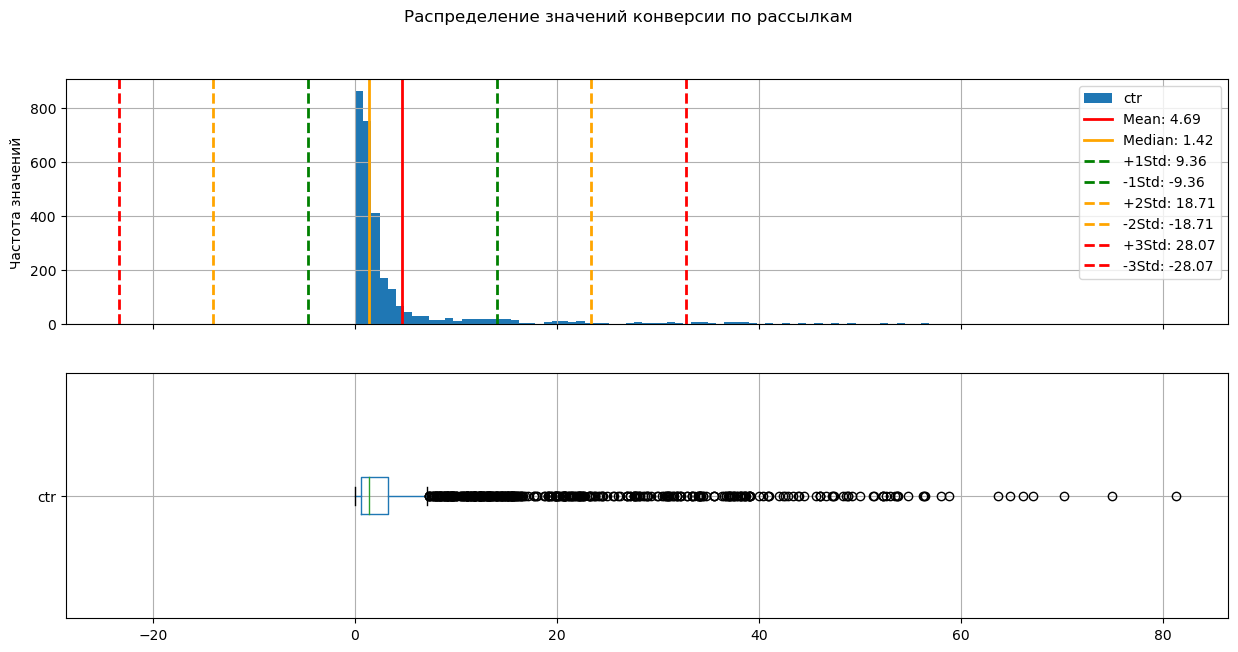

Данные не распределены нормально для 1% уровня значимости теста Андерсона


In [113]:
num_stat_description(sum_table_campaign, 'ctr', 100, 'Распределение значений конверсии по рассылкам')

В распределении конверсии числа открытий в переходы (CTR) по ссылке аналичная картина, распределение несимметричное, есть выбросы справа.

Среднее значение CTR - 4.69%, стандартное отклонение - 9,36%.
Значения выше 30% также следует удалить, по тем же причинам.

In [114]:
# удаляем аномалии и выбросы
sum_table_campaign = sum_table_campaign.query('conversion < 10 and ctr < 20')

In [115]:
# сделаем выборку - id последних по дате трех рассылок в разрезе каждого клиента 
# чтобы связать затем фрейм со входящими признаками в разрезе клиентов с данными по эффективности рассылок

# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее последние 3 события по убыванию даты для каждого клиента
messages_top3 = messages.groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['bulk_campaign_id'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'last_camp_id_{x+1}')

In [116]:
# результат
messages_top3

,last_camp_id_1,last_camp_id_2,last_camp_id_3
client_id,,,
1515915625468060902,14502.0,14502.0,14502.0
1515915625468061003,14624.0,14641.0,14625.0
1515915625468061099,14641.0,14624.0,14625.0
1515915625468061100,14648.0,14648.0,14653.0
1515915625468061170,14648.0,14657.0,14649.0
...,...,...,...
1515915626010183608,14648.0,14648.0,14653.0
1515915626010221592,14648.0,14648.0,14653.0
1515915626010234726,14656.0,NaN,NaN


In [117]:
messages_top3.shape

(53329, 3)

In [118]:
# присоединим к полученному фрейму в разрезе клиентов данные эффективности рассылок по id рассылки 

# Предопределение ключей и суффиксов
keys = ['last_camp_id_1', 'last_camp_id_2', 'last_camp_id_3']
suffixes = ['_1', '_2', '_3']

# Начальный DataFrame
last_camp_effect = messages_top3.copy()

# Цикл для объединения и переименования колонок
for key, suffix in zip(keys, suffixes):
    last_camp_effect = pd.merge(last_camp_effect, sum_table_campaign[['ctr', 'conversion']], 
                                how='left', left_on=key, right_on='bulk_campaign_id')
    last_camp_effect = last_camp_effect.rename(columns={'ctr': f'ctr{suffix}', 'conversion': f'conversion{suffix}'})

last_camp_effect = pd.concat([pd.DataFrame(messages_top3.index), last_camp_effect], axis=1)
last_camp_effect.head(3)

,client_id,last_camp_id_1,last_camp_id_2,last_camp_id_3,ctr_1,conversion_1,ctr_2,conversion_2,ctr_3,conversion_3
0,1515915625468060902,14502.0,14502.0,14502.0,0.697587,0.107945,0.697587,0.107945,0.697587,0.107945
1,1515915625468061003,14624.0,14641.0,14625.0,0.193996,0.325267,0.275704,0.350310,0.228655,0.230508
2,1515915625468061099,14641.0,14624.0,14625.0,0.275704,0.350310,0.193996,0.325267,0.228655,0.230508


In [119]:
# добавим полученные признаки во фрейм с входящими признаками 
df = pd.merge(df, last_camp_effect[['client_id', 'ctr_1', 'conversion_1', 'ctr_2', 'conversion_2', 'ctr_3',
       'conversion_3']], how='left', left_on='client_id', right_on='client_id')

df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,last_active_action_3,days_from_last_active_action_1,days_from_last_active_action_2,days_from_last_active_action_3,ctr_1,conversion_1,ctr_2,conversion_2,ctr_3,conversion_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,click,40.0,43.0,465.0,0.697587,0.107945,0.697587,0.107945,0.697587,0.107945
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,click,86.0,275.0,275.0,0.193996,0.325267,0.275704,0.350310,0.228655,0.230508
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,click,171.0,244.0,372.0,0.275704,0.350310,0.193996,0.325267,0.228655,0.230508


In [120]:
# тест Манна-Уитни по времени последнего события

# заполним пропуски чтобы тест корректно отработал
df_copy = df[['target', 'ctr_1', 'conversion_1', 'ctr_2', 'conversion_2', 'ctr_3', 'conversion_3']]
df_copy = df_copy.fillna(-1)

subset_of_features = ['ctr_1', 'conversion_1', 'ctr_2', 'conversion_2', 'ctr_3', 'conversion_3']

for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

ctr_1
Статистика U: 24428912.5
p-значение: 0.03164416903536503
Нет статистически значимых различий (не отвергаем нулевую гипотезу)

conversion_1
Статистика U: 25939349.0
p-значение: 2.0430151199659883e-08
Есть статистически значимые различия (отвергаем нулевую гипотезу)

ctr_2
Статистика U: 25544630.0
p-значение: 2.733104117762853e-06
Есть статистически значимые различия (отвергаем нулевую гипотезу)

conversion_2
Статистика U: 27155872.5
p-значение: 5.811565879397158e-17
Есть статистически значимые различия (отвергаем нулевую гипотезу)

ctr_3
Статистика U: 25382026.5
p-значение: 1.700548787064317e-05
Есть статистически значимые различия (отвергаем нулевую гипотезу)

conversion_3
Статистика U: 27120742.0
p-значение: 1.5208409945423718e-16
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Здесь мы можем видеть, что новые признаки имеют значение для предсказания таргета, за исключением одного, как ни странно - это CTR именно с последней рассылки.

Но тут нужно отметить, что это при заданном нами досаточно высоком уровне статистической значимости внутри теста, а именно 1%.
В случае порога 5% - данный показатель был бы значимым. 

Собственно уровень вероятности того, что данный результат случаен - составляет 3,1%.

Поэтому с небольшой натяжкой, но можно утверждать что все признаки, а именно эффективность*) трех последних рассылок имеет статистическую значимость с точки зрения  разделения таргета.

*эффективность и в части переходов, и в части покупок

#### Попадание рассылки в нужный канал

Подведем еще промежуточный итог.
Мы добавили такой признак, был ли клик у клиента и как давно.
Логично, если если был и недавно, то это добавляет к вероятности совершить покупку.

Затем добавили эффективность рассылки - конверсию покупок, которая может подсказывать модели насколько вероятно, что после клика клиент уже купит. Если конверсия рассылки ниже среднего, то вероятность меньше, относительно случаев, если конверсия рассылки выше. 

Теперь сделаем еще один входящий признак - соответствие канала рассылки (последних рассылок), тому каналу, которым пользуется клиент. То есть эффективность может быть и выше среднего, но клиент просто напросто не пользуется, к примеру почтой, а расссылка была по почте.

In [121]:
# находим чем (в каком канале) чаще пользуется клиент
# для этого посмотрим где чаще он откликался (клик или открытие) от общего количества соответствующих рассылок

# фильтрация активных действий клиента (кликов и открытий)
relevant_events = messages[messages['event'].isin(['click', 'open'])]

# группировка данных для расчета количества рассылок и соответствующих действий по каналам (почта и пуш)
total_counts_email = messages[messages['channel'] == 'email'].groupby('client_id').size()
total_counts_push = messages[messages['channel'] == 'mobile_push'].groupby('client_id').size()

relevant_counts_email = relevant_events[relevant_events['channel'] == 'email'].groupby('client_id').size()
relevant_counts_push = relevant_events[relevant_events['channel'] == 'push'].groupby('client_id').size()

# расчет долей
email_relevant_ratio = relevant_counts_email.div(total_counts_email, fill_value=0)
push_relevant_ratio = relevant_counts_push.div(total_counts_push, fill_value=0)

# бъединение результатов в одну таблицу
final_table = pd.DataFrame({
    'email_relevant_ratio': email_relevant_ratio,
    'push_relevant_ratio': push_relevant_ratio
})

In [122]:
final_table

,email_relevant_ratio,push_relevant_ratio
client_id,,
1515915625468060902,0.254237,NaN
1515915625468061003,0.060606,NaN
1515915625468061099,0.137363,0.0
1515915625468061100,NaN,0.0
1515915625468061170,0.173267,0.0
...,...,...
1515915626010183608,NaN,0.0
1515915626010221592,NaN,0.0
1515915626010234726,NaN,0.0


In [123]:
# очистим данные от inf и пустых значений
final_table.replace([np.inf, -np.inf], np.nan, inplace=True)
final_table = final_table.fillna(0)

final_table 

,email_relevant_ratio,push_relevant_ratio
client_id,,
1515915625468060902,0.254237,0.0
1515915625468061003,0.060606,0.0
1515915625468061099,0.137363,0.0
1515915625468061100,0.000000,0.0
1515915625468061170,0.173267,0.0
...,...,...
1515915626010183608,0.000000,0.0
1515915626010221592,0.000000,0.0
1515915626010234726,0.000000,0.0


In [124]:
# добавление столбца с предпочтительным каналом для клиента

def categorize_preference(row):
    if row['email_relevant_ratio'] == 0 and row['push_relevant_ratio'] == 0:
        return 4  # Не откликается на рассылку
    elif abs(row['email_relevant_ratio'] - row['push_relevant_ratio']) <= 0.05:
        return 3  # Нет существенных предпочтений
    elif row['email_relevant_ratio'] > row['push_relevant_ratio']:
        return 1  # Предпочитает email
    else:
        return 2  # Предпочитает push

In [125]:
final_table['prefer_channel'] = final_table.apply(categorize_preference, axis=1)

In [126]:
final_table

,email_relevant_ratio,push_relevant_ratio,prefer_channel
client_id,,,
1515915625468060902,0.254237,0.0,1
1515915625468061003,0.060606,0.0,1
1515915625468061099,0.137363,0.0,1
1515915625468061100,0.000000,0.0,4
1515915625468061170,0.173267,0.0,1
...,...,...,...
1515915626010183608,0.000000,0.0,4
1515915626010221592,0.000000,0.0,4
1515915626010234726,0.000000,0.0,4


In [127]:
# отфильтруем в каком канале были 3 последние по дате рассылки для каждого клиента


# сортируем данные по client_id и date в обратном порядке 
messages = messages.sort_values(by=['client_id', 'date'], ascending=[True, False])

# получаем последнее действие для каждого клиента
messages_top3 = messages.groupby('client_id').head(3)

# cоздаем новый DataFrame с датами последних действий в отдельных столбцах
messages_top3 = messages_top3.groupby('client_id')['channel'].apply(
    lambda x: x.reset_index(drop=True)).unstack().rename(columns=lambda x: f'channel_of_last_message_{x+1}')

messages_top3.head(3)

,channel_of_last_message_1,channel_of_last_message_2,channel_of_last_message_3
client_id,,,
1515915625468060902,email,email,email
1515915625468061003,email,email,email
1515915625468061099,email,email,email


In [128]:
# добавим предпочитаемый канал клиента к полученному фрейму
messages_top3 = pd.merge(messages_top3, final_table['prefer_channel'], how='left', on='client_id')
messages_top3.head(3)

,channel_of_last_message_1,channel_of_last_message_2,channel_of_last_message_3,prefer_channel
client_id,,,,
1515915625468060902,email,email,email,1
1515915625468061003,email,email,email,1
1515915625468061099,email,email,email,1


In [129]:
# категоризируем результат относительно предпочтений клиента и канала послених рассылок
# если канал совпал - 1
# если не совпало - 2
# если нет существенных предпочтений - 3 
# если клиент не откликается на рассылку - 4

def add_match_preference_columns(df):
    def check_preference(row, channel_col):
        if row['prefer_channel'] == 1: 
            return 1 if row[channel_col] == 'email' else 2
        elif row['prefer_channel'] == 2:
            return 1 if row[channel_col] == 'push' else 2
        elif row['prefer_channel'] == 3:
            return 3
        elif row['prefer_channel'] == 4:
            return 4
        return 0  # на случай непредвиденного значения

    # обработка трех последних рассылок
    for i in range(1, 4):
        channel_col = f'channel_of_last_message_{i}'
        new_col = f'match_preference_{i}'
        df[new_col] = df.apply(lambda row: check_preference(row, channel_col), axis=1)
    
    return df


channel_match = add_match_preference_columns(messages_top3)
channel_match

,channel_of_last_message_1,channel_of_last_message_2,channel_of_last_message_3,prefer_channel,match_preference_1,match_preference_2,match_preference_3
client_id,,,,,,,
1515915625468060902,email,email,email,1,1,1,1
1515915625468061003,email,email,email,1,1,1,1
1515915625468061099,email,email,email,1,1,1,1
1515915625468061100,mobile_push,mobile_push,mobile_push,4,4,4,4
1515915625468061170,mobile_push,email,mobile_push,1,2,1,2
...,...,...,...,...,...,...,...
1515915626010183608,mobile_push,mobile_push,mobile_push,4,4,4,4
1515915626010221592,mobile_push,mobile_push,mobile_push,4,4,4,4
1515915626010234726,mobile_push,NaN,NaN,4,4,4,4


In [130]:
# добавим новый признак к фрейму со входящими признаками
df = pd.merge(df, channel_match[['match_preference_1', 'match_preference_2', 'match_preference_3']], 
              how='left', left_on='client_id', right_on='client_id')

df.head(3)

,client_id,target,mean_time,quantity,rev,av_bill,days_after_purch_1,days_after_purch_2,days_after_purch_3,last_purch_1_cat_level_1,...,days_from_last_active_action_3,ctr_1,conversion_1,ctr_2,conversion_2,ctr_3,conversion_3,match_preference_1,match_preference_2,match_preference_3
0,1515915625468060902,0,0.0,7,6993.0,999.000000,630,630.0,630.0,4.0,...,465.0,0.697587,0.107945,0.697587,0.107945,0.697587,0.107945,1.0,1.0,1.0
1,1515915625468061003,1,0.0,7,16235.0,2319.285714,408,408.0,408.0,4.0,...,275.0,0.193996,0.325267,0.275704,0.350310,0.228655,0.230508,1.0,1.0,1.0
2,1515915625468061099,0,NaN,1,299.0,299.000000,640,NaN,NaN,4.0,...,372.0,0.275704,0.350310,0.193996,0.325267,0.228655,0.230508,1.0,1.0,1.0


In [131]:
# тест Манна-Уитни по времени последнего события

# заполним пропуски чтобы тест корректно отработал
df_copy = df[['target', 'match_preference_1', 'match_preference_2', 'match_preference_3']]
df_copy = df_copy.fillna(-1)

subset_of_features = ['match_preference_1', 'match_preference_2', 'match_preference_3']
for feature in subset_of_features:
    print (feature)
    MWtest(df_copy, feature=feature, alpha=0.01)
    print('')

match_preference_1
Статистика U: 25433986.0
p-значение: 5.994392451250281e-06
Есть статистически значимые различия (отвергаем нулевую гипотезу)

match_preference_2
Статистика U: 25482568.5
p-значение: 3.3959042596002836e-06
Есть статистически значимые различия (отвергаем нулевую гипотезу)

match_preference_3
Статистика U: 25667462.5
p-значение: 3.050825991638136e-07
Есть статистически значимые различия (отвергаем нулевую гипотезу)



Данные признаки также имеют статистическую значимость и могут быть включены в модель.

#### Выводы по разделу:

В итоге, на таргет имеет вероятное влияние следующие факторы/входящие признаки:
- среднее время между покупками;
- как давно была последняя покупка (и предыдущие покупки);
- количество покупок и производные от нее - выручка клиента, средний чек клиента.


- категории последних 3 покупок (что покупали);
- подобие между последней и предпоследней покупкой;
- последние 3 события/действия по рассылке;
- как давно были последние три события/действия по рассылке;

- также имеет значение эффективность последних рассылок, которые получал клиент;
- и по какому каналу были последние рассылки и какие предпочтения у клиента относительно канала рассылки.

И есть еще такая деталь, как:
- 5 уровень ирерархии в описании категории не имеет значимости для предсказания таргета во всех трех последних покупках;
- а также 1-3 уровень иерархии в первой покупке.

## Моделирование

In [132]:
df.shape

(49849, 50)

In [133]:
df.columns.to_list()

['client_id',
 'target',
 'mean_time',
 'quantity',
 'rev',
 'av_bill',
 'days_after_purch_1',
 'days_after_purch_2',
 'days_after_purch_3',
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_1_cat_level_5',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_2_cat_level_5',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'last_purch_3_cat_level_5',
 'vector_category_purch_1',
 'vector_category_purch_2',
 'vector_category_purch_3',
 'distance_1_2',
 'distance_3_2',
 'last_action_1',
 'last_action_2',
 'last_action_3',
 'days_from_last_action_1',
 'days_from_last_action_2',
 'days_from_last_action_3',
 'last_active_action_1',
 'last_active_action_2',
 'last_active_action_3',
 'days_from_last_active_action_1',
 'days_from_last_active_action_2',
 'days_from_last_active

In [134]:
# выделяем тестовую выборку
data_train, data_test = train_test_split (df, stratify = df['target'], random_state=RANDOM_STATE, test_size=TEST_SIZE)

In [135]:
data_train.shape

(37386, 50)

In [169]:
# создаём списки с названиями входящих признаков для модели

# порядковые категориальные
ord_columns = [ 
    
 'last_action_1',
 'last_action_2',
 'last_action_3',
    
 'last_active_action_1',
 'last_active_action_2',
 'last_active_action_3',
]

# количественные
num_columns = [

 'mean_time',
 'quantity',
 'rev',
 'av_bill',
    
 'days_after_purch_1',
 'days_after_purch_2',
 'days_after_purch_3',
    
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',

 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',

 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',

    
 'distance_1_2',
 'distance_3_2',

 'days_from_last_action_1',
 'days_from_last_action_2',
 'days_from_last_action_3',

 'days_from_last_active_action_1',
 'days_from_last_active_action_2',
 'days_from_last_active_action_3',
    
 'ctr_1',
 'conversion_1',
 'ctr_2',
 'conversion_2',
 'ctr_3',
 'conversion_3',
    
 'match_preference_1',
 'match_preference_2',
 'match_preference_3'


]

all_input_features = ord_columns + num_columns

# разделяем входящие признаки и таргет в тренировочном датасете
X = data_train[all_input_features]
y = data_train['target']

In [170]:
all_input_features

['last_action_1',
 'last_action_2',
 'last_action_3',
 'last_active_action_1',
 'last_active_action_2',
 'last_active_action_3',
 'mean_time',
 'quantity',
 'rev',
 'av_bill',
 'days_after_purch_1',
 'days_after_purch_2',
 'days_after_purch_3',
 'last_purch_1_cat_level_1',
 'last_purch_1_cat_level_2',
 'last_purch_1_cat_level_3',
 'last_purch_1_cat_level_4',
 'last_purch_2_cat_level_1',
 'last_purch_2_cat_level_2',
 'last_purch_2_cat_level_3',
 'last_purch_2_cat_level_4',
 'last_purch_3_cat_level_1',
 'last_purch_3_cat_level_2',
 'last_purch_3_cat_level_3',
 'last_purch_3_cat_level_4',
 'distance_1_2',
 'distance_3_2',
 'days_from_last_action_1',
 'days_from_last_action_2',
 'days_from_last_action_3',
 'days_from_last_active_action_1',
 'days_from_last_active_action_2',
 'days_from_last_active_action_3',
 'ctr_1',
 'conversion_1',
 'ctr_2',
 'conversion_2',
 'ctr_3',
 'conversion_3',
 'match_preference_1',
 'match_preference_2',
 'match_preference_3']

In [171]:
# сэмплинг
sampler = RandomOverSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(X, y) 

In [172]:
# предобработка категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')),
    ('encoder', OrdinalEncoder(categories=[        
                                            
        ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                    'send', 'open','click','subscribe','purchase'], # last_action_1
                                             
        ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                    'send', 'open','click','subscribe','purchase'], # last_action_2
                                             
        ['complain', 'unsubscribe','hbq_spam','hard_bounce','soft_bounce', 'close',
                    'send', 'open','click','subscribe','purchase'], # last_action_3
                                             
        ['click'], # 'last_active_action_1',
                                             
        ['click'], # 'last_active_action_2',
                                             
        ['click'], # 'last_active_action_3',
],   
                               
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    
    ('imputer2', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1))
])

# предобработка числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', 'passthrough')  
])

# объединение предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ord_columns),
        ('num', numeric_transformer, num_columns),
    ])

# создание пайплайна с моделью
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', LGBMClassifier())
])

### SKLearn GradientBoosting

In [173]:
# cловари гиперпараметров для моделей
param_grid = [
    {

        'models': [HistGradientBoostingClassifier()],
        'models__learning_rate': [0.1],
        'models__max_depth': [4],
        'models__l2_regularization': [0.5],
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     
    } 
]

In [174]:
%%time
# поиск лучшей модели и ее гиперпараметров
model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

model.fit(X_resample, y_resample)
print(f'Лучшая модель: {model.best_estimator_.named_steps["models"]}')
print(f'Метрика ROC лучшей модели по результатам кросс-валидации: {round(model.best_score_, 2)}')

Лучшая модель: HistGradientBoostingClassifier(l2_regularization=0.5, max_depth=4)
Метрика ROC лучшей модели по результатам кросс-валидации: 0.91
CPU times: total: 7.52 s
Wall time: 12.5 s


In [175]:
%%time
# расчет метрики модели на тестовой выборке
y_pred_proba = model.predict_proba(data_test[all_input_features])[:,1]
print(f"Метрика roc_auc модели на тестовой выборке: {roc_auc_score(data_test['target'], y_pred_proba)}")

Метрика roc_auc модели на тестовой выборке: 0.765928304562437
CPU times: total: 469 ms
Wall time: 79.8 ms


### LGBM

In [176]:
# cловари гиперпараметров для моделей
param_grid = [
    {

        'models': [LGBMClassifier(random_state=42)],
        'models__learning_rate': [0.1],
        'models__n_estimators': [40],
        'models__max_depth': [4],
       
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
     
    } 
]

In [177]:
%%time
# поиск лучшей модели и ее гиперпараметров
model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

model.fit(X_resample, y_resample)
print(f'Лучшая модель: {model.best_estimator_.named_steps["models"]}')
print(f'Метрика ROC лучшей модели по результатам кросс-валидации: {round(model.best_score_, 2)}')

[LightGBM] [Info] Number of positive: 36665, number of negative: 36665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6367
[LightGBM] [Info] Number of data points in the train set: 73330, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [178]:
%%time
# расчет метрики модели на тестовой выборке
y_pred_proba = model.predict_proba(data_test[all_input_features])[:,1]
print(f"Метрика roc_auc модели на тестовой выборке: {roc_auc_score(data_test['target'], y_pred_proba)}")

Метрика roc_auc модели на тестовой выборке: 0.7840469811012027
CPU times: total: 469 ms
Wall time: 74.1 ms


### CatBoost

In [179]:
# cловари гиперпараметров для моделей
param_grid = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__iterations': [40],
        'models__learning_rate': [0.1],
        'models__depth': [4],
        
        'models__l2_leaf_reg': [0.3],
   
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    } 
]

In [180]:
%%time
# поиск лучшей модели и ее гиперпараметров
model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=10,
    scoring='roc_auc',
    n_jobs=-1
)

model.fit(X_resample, y_resample)
print(f'Лучшая модель: {model.best_estimator_.named_steps["models"]}')
print(f'Метрика ROC лучшей модели по результатам кросс-валидации: {round(model.best_score_, 2)}')

Лучшая модель: <catboost.core.CatBoostClassifier object at 0x0000018C88D10290>
Метрика ROC лучшей модели по результатам кросс-валидации: 0.82
CPU times: total: 10.5 s
Wall time: 16.5 s


In [181]:
# вывод гиперпараметров лучшей модели
params = model.best_estimator_.named_steps["models"]
print("Гиперпараметры лучшей модели:", params.get_params())

Гиперпараметры лучшей модели: {'silent': True, 'random_state': 25, 'depth': 4, 'iterations': 40, 'l2_leaf_reg': 0.3, 'learning_rate': 0.1}


In [182]:
%%time
# расчет метрики модели на тестовой выборке
y_pred_proba = model.predict_proba(data_test[all_input_features])[:,1]
print(f"Метрика roc_auc модели на тестовой выборке: {roc_auc_score(data_test['target'], y_pred_proba)}")

Метрика roc_auc модели на тестовой выборке: 0.7858277768687446
CPU times: total: 219 ms
Wall time: 227 ms


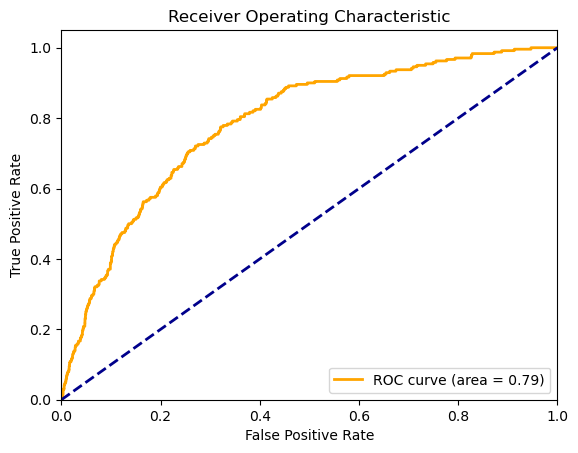

In [183]:
# график ROC лучшей модели

fpr, tpr, _ = roc_curve(data_test['target'], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

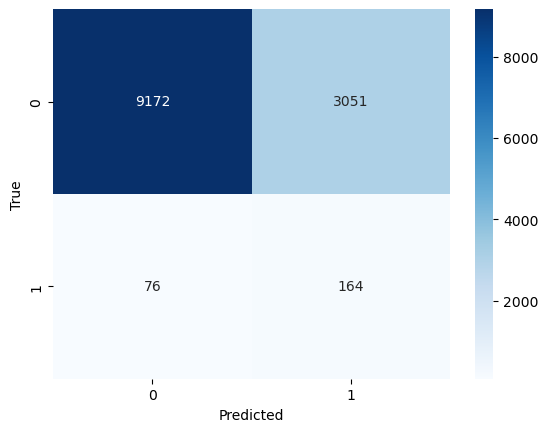

In [184]:
# confusion matrix лучшей модели

y_pred = model.predict(data_test[all_input_features])
cm = confusion_matrix(data_test['target'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [185]:
# дополнительные метрики

print(round(accuracy_score(data_test['target'], y_pred), 2))
print(round(precision_score(data_test['target'], y_pred), 2))
print(round(recall_score(data_test['target'], y_pred), 2))

0.75
0.05
0.68


In [186]:
# подготовка данных для оценки важности признаков по Шепли
best_model = model.best_estimator_.named_steps['models']
preprocessor = model.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X[all_input_features])

In [187]:
# расчет коэффициентов Шепли по выборочным данным
X_test_preprocessed_shap = shap.sample(X_train_preprocessed, 100, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(best_model, X_test_preprocessed_shap)
shap_values = explainer(X_test_preprocessed_shap)

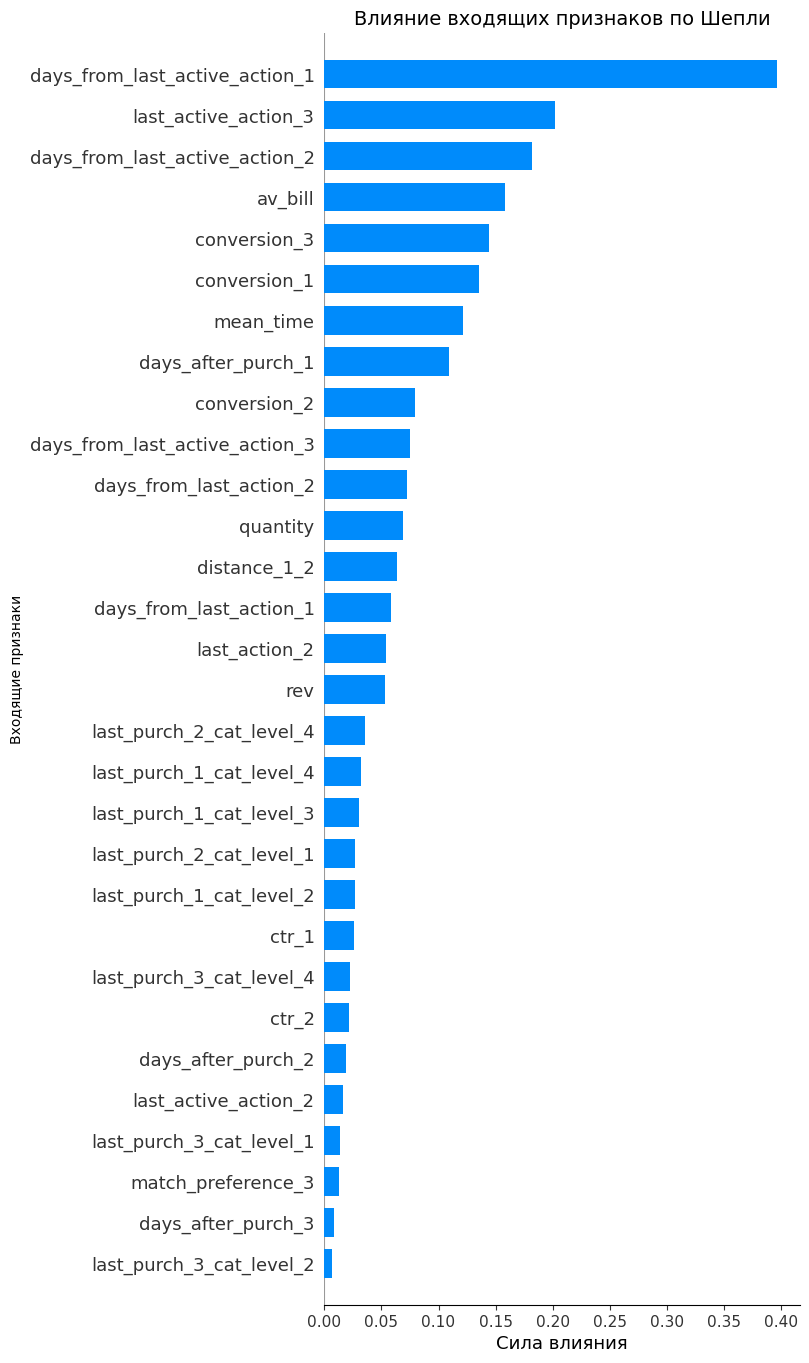

In [188]:
# вывод графика 
shap.summary_plot(shap_values, all_input_features, plot_type="bar", max_display=30, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Влияние входящих признаков по Шепли', fontdict={"size":14})
ax.set_ylabel('Входящие признаки')
ax.set_xlabel('Сила влияния')
plt.show()

### Выводы по этапу моделирования

Самой лучшей моделью оказалась модель на основе CatBoost. Показатель ROC-AUC на тестовой выборке составил 79%.

Но отрыв от других моделей несущественный - несколько процентов (в случае LGBM - вообще доли процента).
При этом нужно отметить, что:
- с точки зрения модели имеют значение - хоть и небольшое - все входящие признаки (включая уровни иерархии 1-3 в первой покупке, которые были под сомнением после теста Манна-Уитни).


Тем не менее влияние данного фактора находится на грани случайности:
- при других реализациях, когда изменяется входящее значение RANDOM STATE (который определяет разбиение на тестовую и тренировочную выборку, работу сэмплера) - данный фактор уже не имеет положительного вклада;


Также нужно отметить что, метрика качества также подвержена небольшому дрейфу в зависимости от RANDOM STATE:
- усредненное значение метрики качества модели при различных значениях стремится к 77%, с разбросом вокруг среднего +/- 2 процентных пункта.

Применение других сэмлеров - SMOTE, ADASYN - ухудшает качество модели относительно OVERSAMPLER, но незначительно - на несколько процентных пунктов. При этом, отсутствие сэмплинга, даже при наличии параметра внутри модели, который включает взвешиваение классов - делает модель нечувствительной к минорному классу вообще.

Еще также следует добавить, что увеличение параметров модели, в сторону усложнения приводит к более высоким показателям на тренировочной выборке, но ухудшению на тестовой, что обусловлено тем, что модель обучается на выборке с оверсэмплингом,  в то время как в тестовой - минорный класс таргета находится в существенном дисбалансе относительно мажорного класса - 2% всего от общего количества.

Самыми существенными факторами, согласно коэффициентов Шепли, оказались (в порядке убывания):
- количество прошедших дней с момента клика клиента;
- эффективность предпоследних  рассылок с точки зрения конверсии;
- среднее время между покупками;
- как давно была последняя покупка;
- количество самих покупок, выручка клиента и средний чек клиента.

Наличие только этих факторов уже дает возможность получить 75-76% ROC-AUC, без добавления таких факторов как категориий покупок, их подобие, и прочие факторы, выделенные в работе.



При этом, нужно отметить что у модели невысокое качество относительно ложноположительных прогнозов - precision составляет всего 5%. Более точное определение минорного класса (тех, кто купит) далее возможно только за счет повышения порога вероятности.
При стандартном пороге срабатывания в 50% модель дает 88 ложноположительных прогнозов и 152 верных пронозов относительно принадлежности к минорному классу (те, кто купят в следующие 90 дней).

Впрочем, итоговое качество по ROC в 79% является также посредственным.

Посмотрим теперь граничные показатели факторов, которые определяют вероятность покупки в ближайшие 90 дней:

In [159]:
# выгрузим вероятности принадлежности к классам (купит/не купит) для тренировочной выборки
probabilities = model.predict_proba(data_train[all_input_features])[:, 1]
data_train['proba'] = probabilities

In [160]:
# создадим пользовательскую функцию, которая будет отображать график:
# по оси абсцисс - входящий признак, по оси ординат - вероятность отнесения к мажорному классу 

def describing (dataset, incoming_feature, target_feature):     
    
    probabilities_range = np.arange(0.5, 1.0, 0.1)
    mean_feature_values = []

    for prob in probabilities_range:
        mean_feature = dataset.query(f'{target_feature} > {prob}')[incoming_feature].mean()
        mean_feature_values.append(mean_feature)

    result_df = pd.DataFrame({'Probability': probabilities_range, 'Mean Feature': mean_feature_values})


    plt.plot(result_df['Mean Feature'], result_df['Probability'], marker='o')

    plt.xlabel(f'Среднее значение {incoming_feature}')
    plt.ylabel('Вероятность')
    plt.title(f'Вероятность отнесения к классу operating в зависимости от значения {incoming_feature}')
    plt.grid(True)
    plt.show()

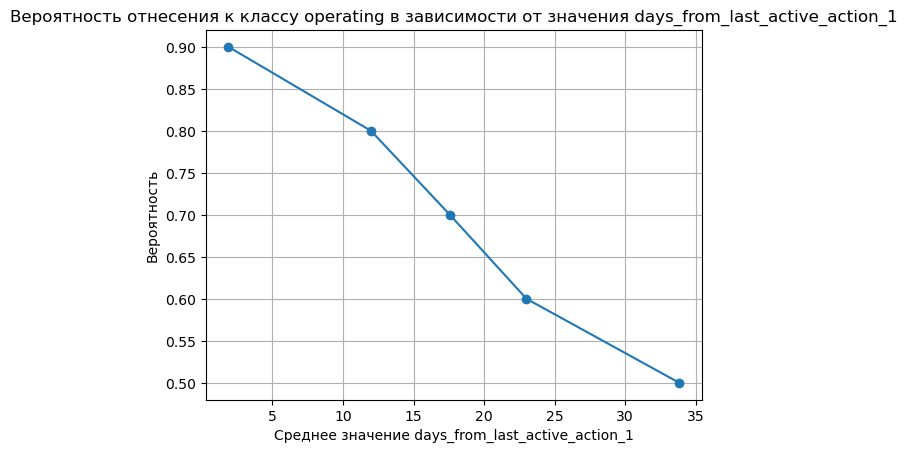

In [161]:
describing (data_train, 'days_from_last_active_action_1', 'proba')   

Здесь мы можем видеть, что если клиент переходил ссылке менее чем 30-35 дней назад - вероятность того, что он купить что-то вырастает выше 50% (при прочих равных). И наоборот, если этот срок больше 35 дней - вероятность покупки снижается ниже 50%.

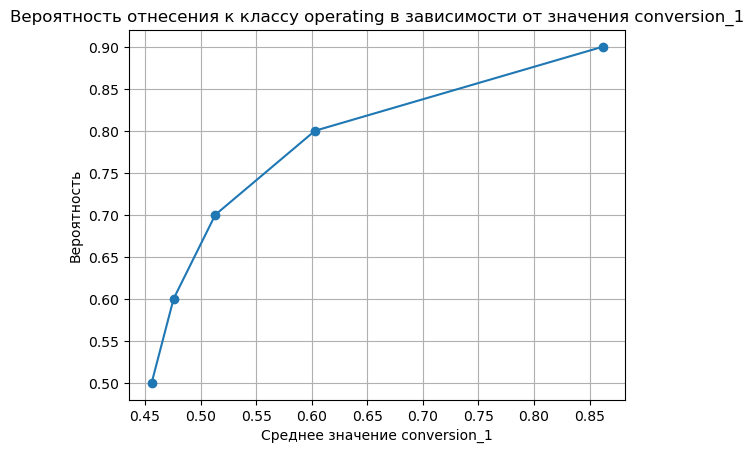

In [162]:
# критичное значение времени - относительно того как давно был клик у клиента 
describing (data_train, 'conversion_1', 'proba')  

Здесь мы можем видеть, что если клиент последняя рассылка, которую он получал, имела конверсию в продажи порядка выше 0,5% - вероятность покупки с его стороны возрастает выше 50%.

При этом следует отметить, что половина рассылок имеет эффективность менее 0,19% (медиана показателя conversion), то есть тут есть потенциал.

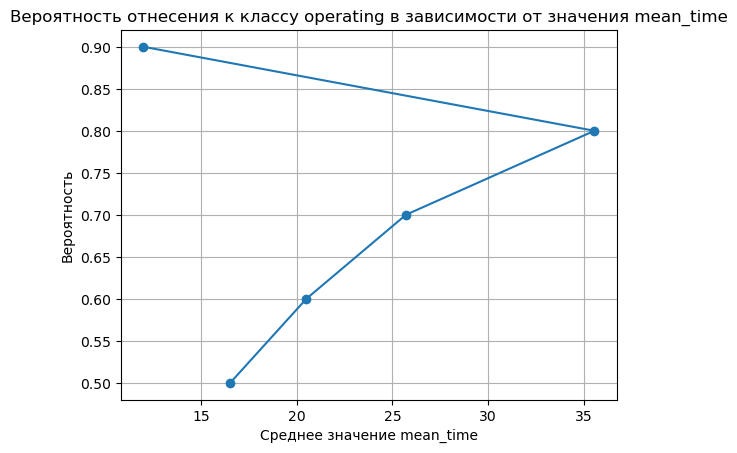

In [163]:
describing (data_train, 'mean_time', 'proba')  

Здесь мы можем видеть, что клиенты, интервал между покупками у которых находится в диапазоне между 20-30 днями - имеют высокую вероятность покупки в ближайшие 90 дней. При этом, как мы видим, зависимость не является однозначной - сначала вероятность растет по мере увеличение интервала между покупками, а затем по мере сокращения интервала между покупками. 

При этом нужно также отметить, как уже было описано в исследовательском анализе, что большинство клиентов, с низкой вероятностью покупки - не имеют такого показателя в принципе, поскольку имеют преимущественно одну покупку в истории и таких порядка 25%.

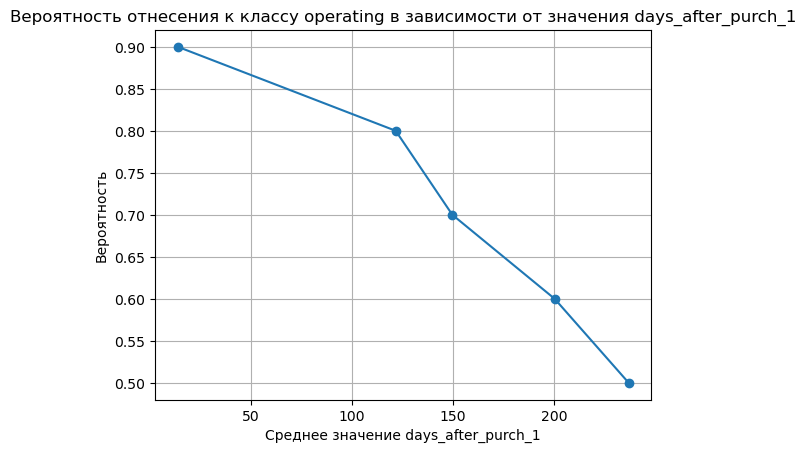

In [164]:
# критичное значение времени - относительно того как давно был клик у клиента 
describing (data_train, 'days_after_purch_1', 'proba')  

Если с момента последней покупки прошло более 200 дней - можно считать что этот клиент уже утерян, и вероятность того что он что-то купит (вернется) - уже менее 50%. 

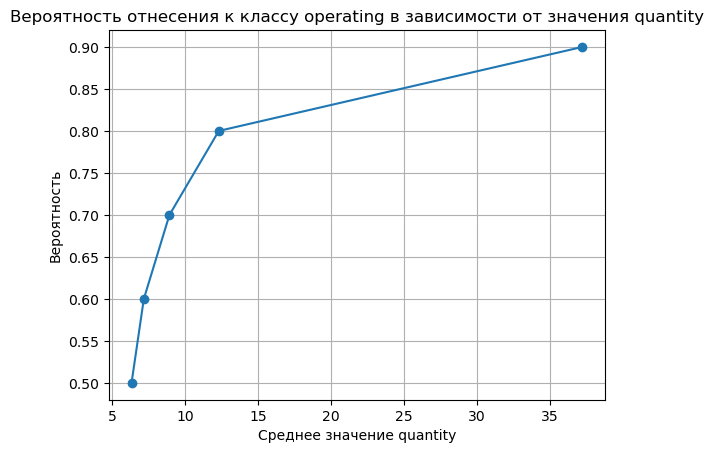

In [165]:
describing (data_train, 'quantity', 'proba') 

Среднее количество покупок, которое должно быть у клиента за историю 2 лет, и который что-либо купит в ближайшие 90 дней - должно быть выше 8 покупок - 1 покупка в квартал - те самые 90 дней =)

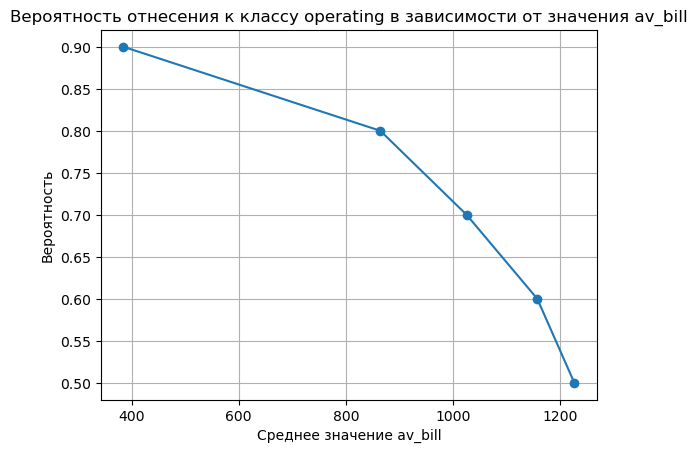

In [166]:
# критичное значение времени - относительно того как давно был клик у клиента 
describing (data_train, 'av_bill', 'proba') 

По мере роста среднего чека - вероятность покупки в следующие 90 дней падает - видимо, наш магазин не для дорогих вещей, здесь не покупают что-то больше 1200 единиц.

## Итоговые выводы.

- (1) Целью данной работы было разработать модель прогнозирования состояния состояния клиента в следующие 90 дней (совершит покупку/не совершит покупку);
- (2) Лучшей моделью для прогнозирования оказалась модель на основе catboost;
- (3) качество модели по метрике ROC на тестовой выборке - 79%.
Качество полученной модели невысокое. 

Самыми важными входящими признаками для прогнозирования состояния являются (указаны по мере убывания):
- количество прошедших дней с момента клика клиента;
- эффективность рассылок с точки зрения конверсии;
- среднее время между покупками;
- как давно была последняя покупка;
- количество самих покупок за историю клиента и средний чек клиента.

Критичные значения вышеуказанных входящих признаков (или портрет лояльного покупателя, который придет в следующие 90 дней):
- количество прошедших дней с момента клика (перехода по ссылке) клиента - 30-35 дней или менее перешел по ссылке в рекламной рассылке;
- эффективность рассылок с точки зрения конверсии - получил рассылку, средняя эффективность которой выше 0,5%;
- среднее время между покупками - порядка 20-25 дней;
- как давно была последняя покупка - покупал что-либо менее 200 дней назад;
- количество самих покупок за историю клиента и средний чек клиента - покупает чаще чем раз в квартал и имеет средний чек порядка 1200 единиц и менее (чем меньше, тем лучше).

Из этого могут следовать такие дальнейшие практические действия, как:
- не следует оставлять клиента без напоминания, если он уже перешел по ссылке  объявления и время с этого момента уже подходит к 30 дням;
- следует проработать причины низкой эффективности большинства рассылок и попробовать увеличить их конверсию (банально, но тем не менее); 
- следует проработать обратную связь от клиентов, которые:
- (а) покупали ранее (более 200 дней назад) несколько раз, но перестали;
- (б) покупали 4-5 раз за набюдаемые период и после этого более не возвращались;
- возможно они укажут на весомые причины в качестве сервиса и/или продаваемых продуктов, которые ограничивают продажи;
- пересмотреть ассортиментный портфель в сторону увеличения продуктов, которые стоят менее 1200 единиц.